In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
# ok, lets test tha tidal stripping at peri
Msun = 1.988*1e30 # msun in kg
kpc = 3.086*1e16 # kpc in m
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
DMmass = sim['SnapNumber_128/Header/MassTable'][1]

def getMet(idd, iddC, snap):
    # get tidal form anything around , lets say I dont know, what i think is close
    # 200 kpc is almost the virial radius, so 100 kpc should be good, and the center always, obviously.
    
    optRadius = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
    offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offGas[0]:offGas[1]]
    rpart = np.sqrt((posPart[:,0] - posGal[0])**2+(posPart[:,1] - posGal[1])**2+(posPart[:,2] - posGal[2])**2)
    index = np.arange(offGas[0], offGas[1])
    ii = np.where(rpart<optRadius)[0]
    indexR = index[ii]
    
    Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][indexR]
    
    TFeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
    TOFe = np.log10((Abund[:,3]/OMass)/(Abund[:,4]/FeMass)) - NoNfe_sun
    
    ife = np.where((np.isnan(TFeH)==False) & (np.isinf(TFeH)==False))
    io = np.where((np.isnan(TOFe)==False) & (np.isinf(TOFe)==False))
    
    TFeH = TFeH[ife]
    TOFe = TOFe[io]

    
    return np.median(TFeH), np.median(TOFe)

In [7]:
# how to test this? let see if not fall, for start
 getMet(4338, 4337, 128)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


(-0.46698427, 0.12886184)

In [8]:
def getperi(gal, center):
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    iddS, iddSC = [], []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        iddS.append(idd)
        iddSC.append(iddC)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    iddS, iddSC = np.array(iddS), np.array(iddSC)
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    iddS = iddS[ir]
    iddSC = iddSC[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    iddS = np.flip(iddS)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap , theID, theIDC = rphys[pre], thesnap[pre], iddS[pre], iddSC[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn, theID, theIDC

In [9]:
sim['SnapNumber_127/SubGroups/SubGroupPos'][4469], sim['SnapNumber_128/SubGroups/SubGroupPos'][4469]

(array([51805.14 , 50152.777, 44156.918], dtype=float32),
 array([51805.14 , 50152.777, 44156.918], dtype=float32))

In [10]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [11]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e16

def getMetTime(gal, central):
    
    z, FeH, OFe, snaplist, dist = [], [], [], [], []
    
    Idlist, snapst  = [], []
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        pos = np.sqrt(np.sum((galPos-groupPos)**2))
        
        if pos>2*r200:
            break
        
        tFeH, tOFe = getMet(idd, iddC, snap)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        snaplist.append(snap)
        FeH.append(tFeH)
        OFe.append(tOFe)
        dist.append(pos)
        
        # and now lost masses
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        z.append(zs)
        
    z, FeH, OFe, snaplist, dist = np.array(z), np.array(FeH),np.array(OFe), np.array(snaplist), np.array(dist)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return z, FeH, OFe, dist, Gas*1e10

In [12]:
# ok, lets test this
gal, cen = 4338, 4337
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


25 25


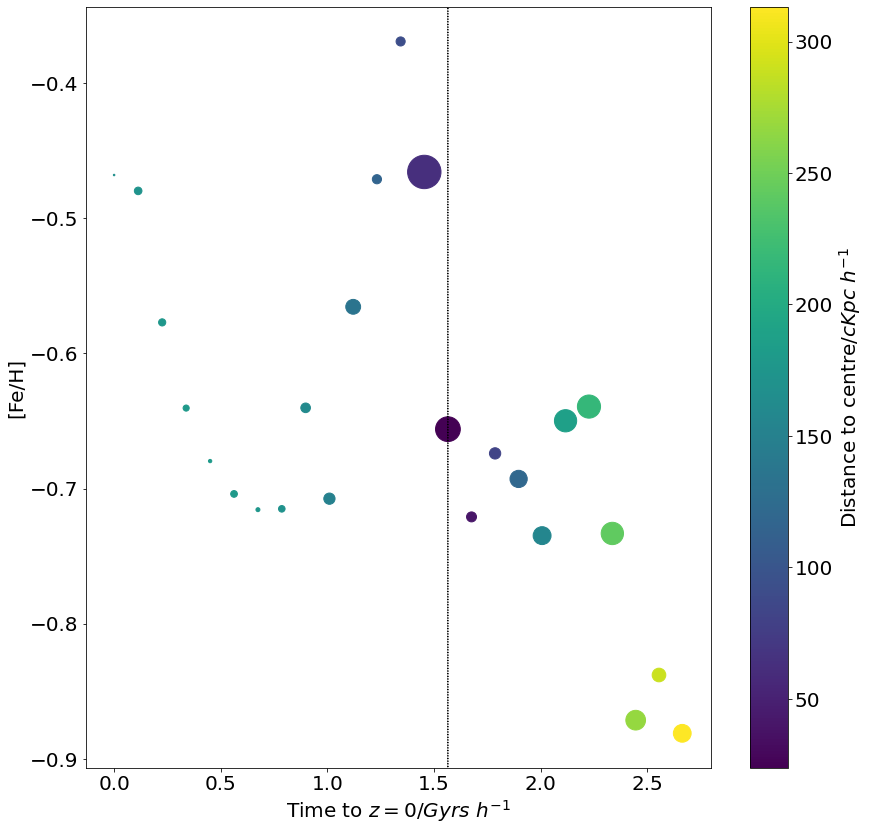

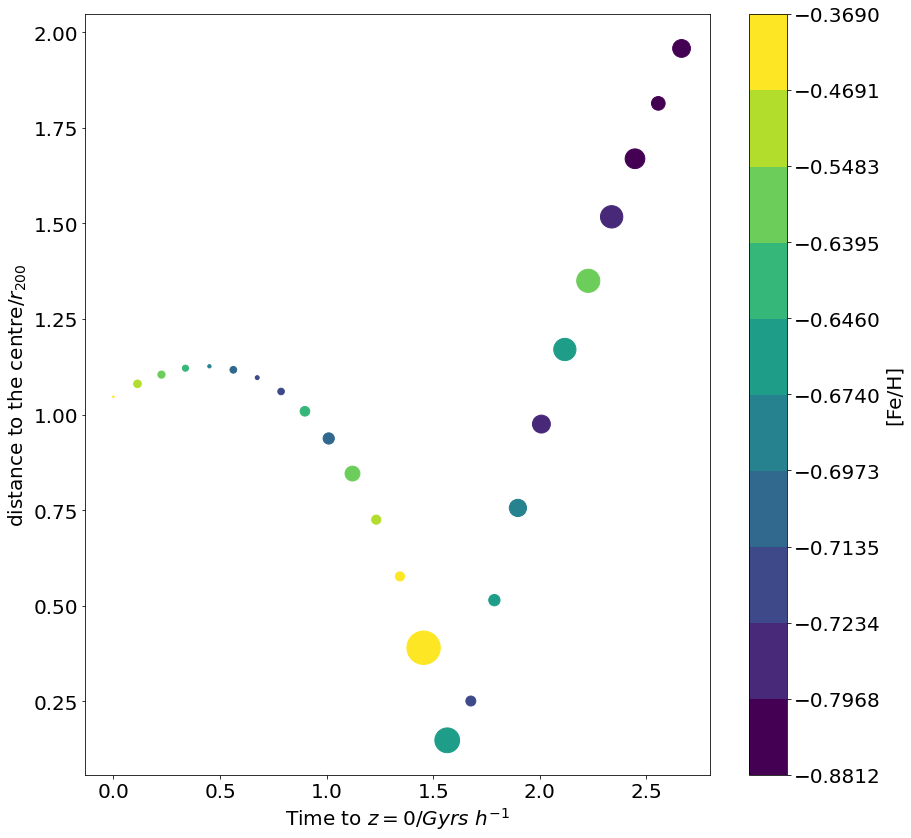

In [13]:
pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4338, Gas_4338 = FeH, Gas

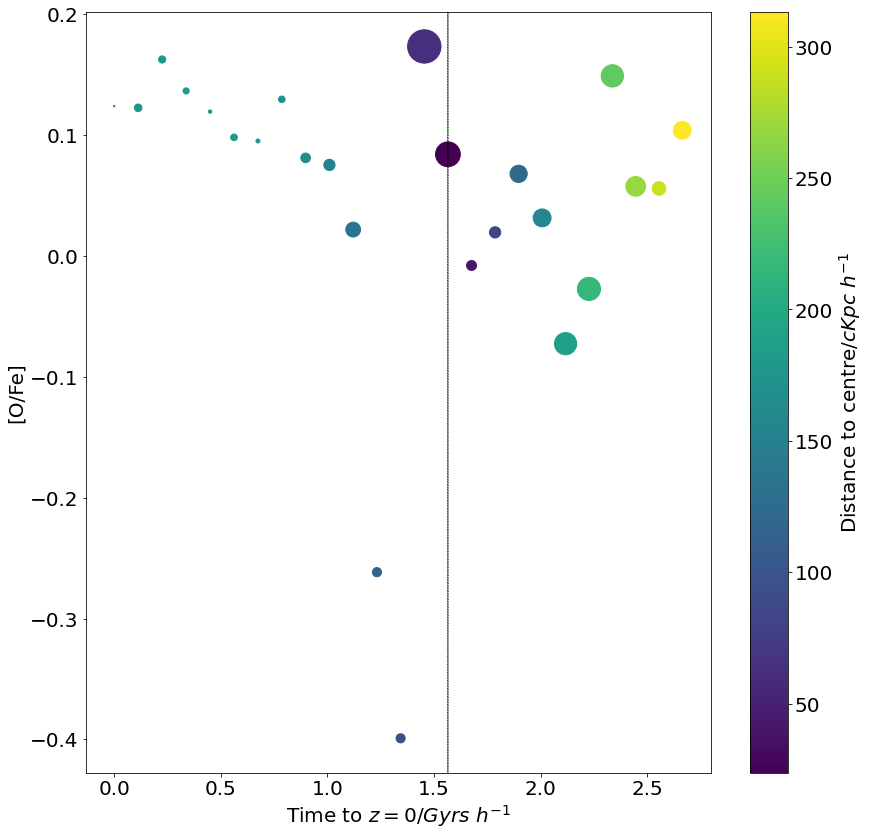

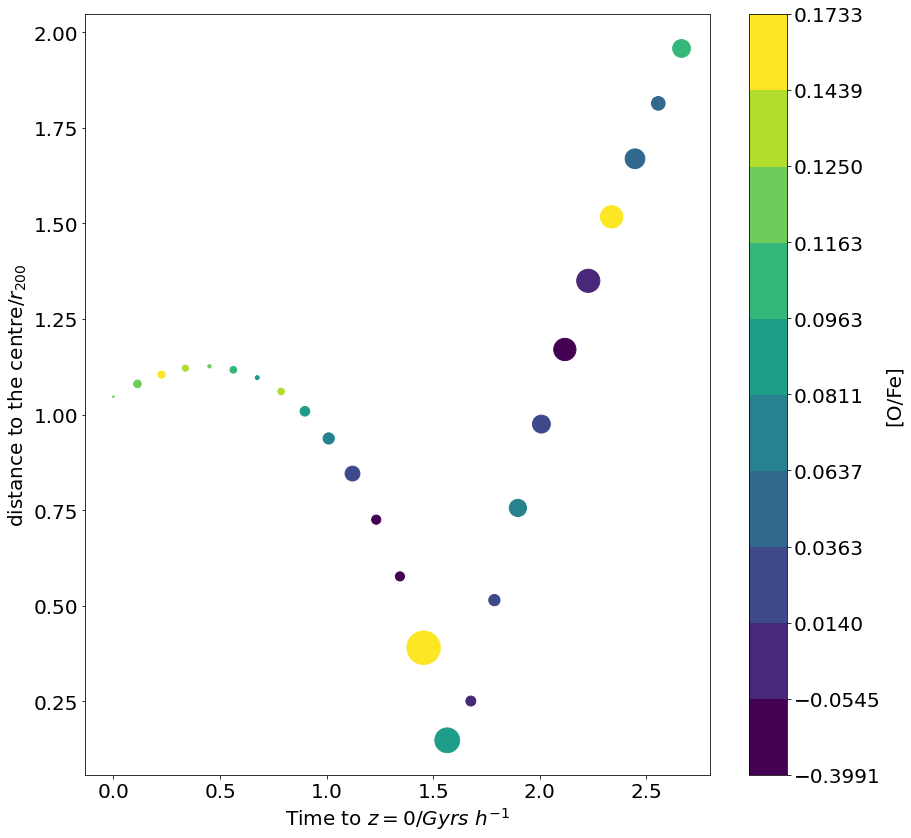

In [14]:
pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
OFe_4338 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


41 41


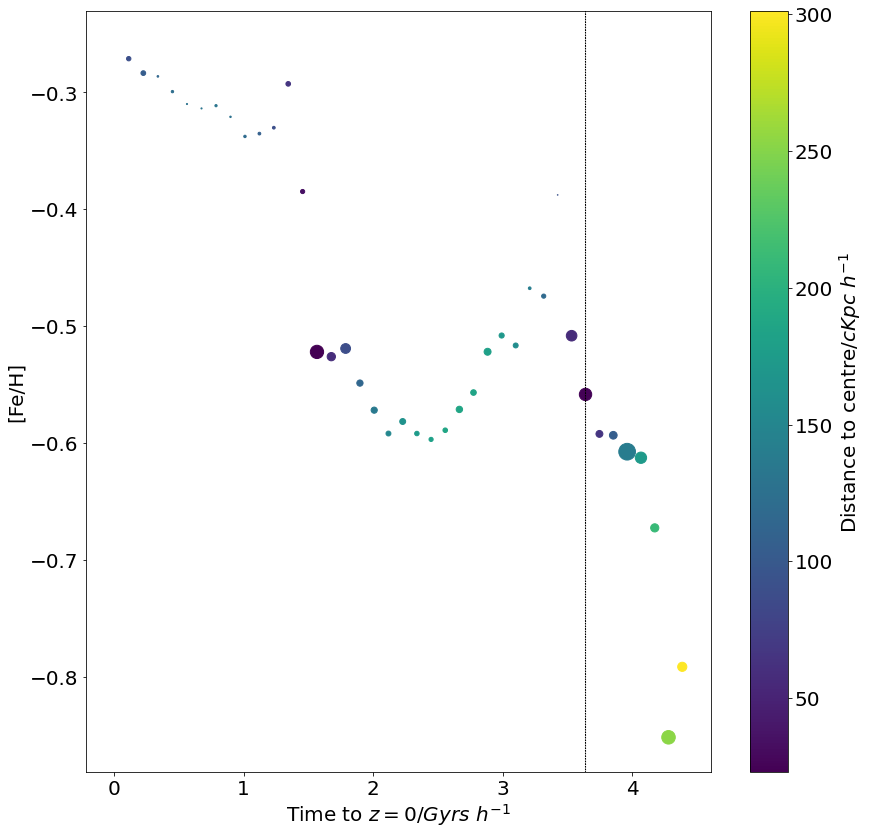

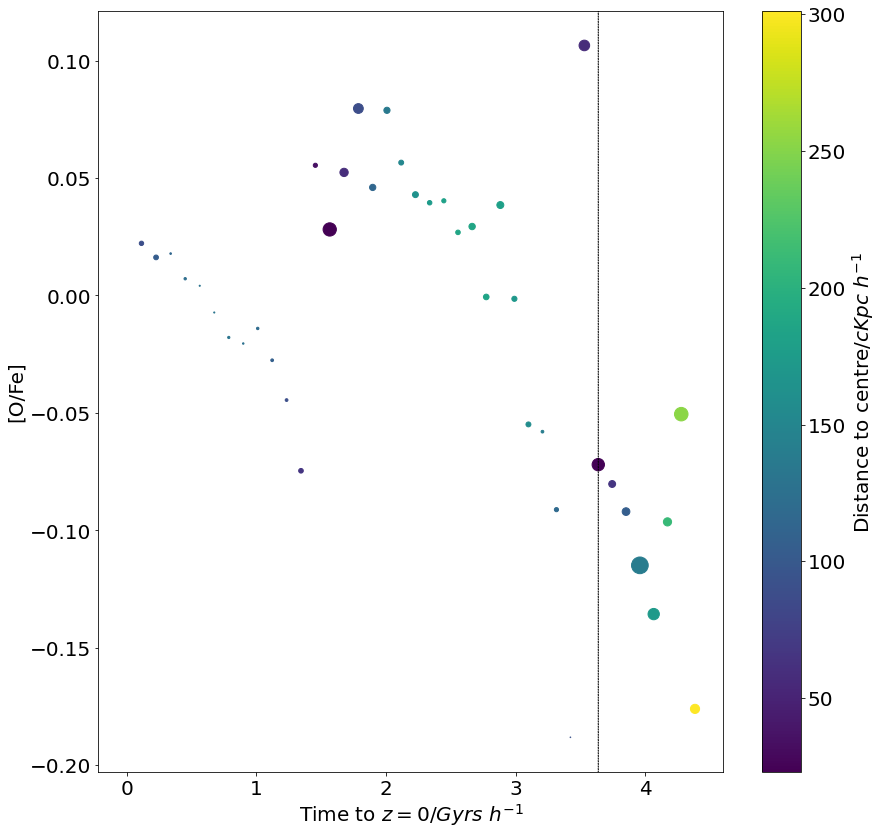

In [15]:
# ok, lets test this
gal, cen = 4339, 4337
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

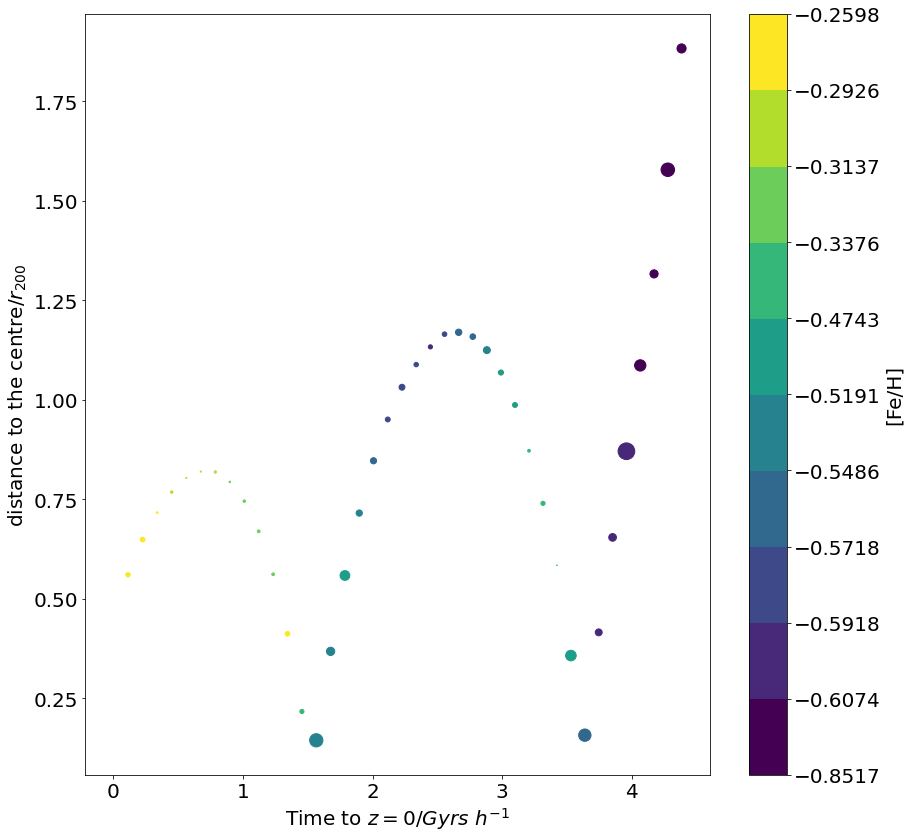

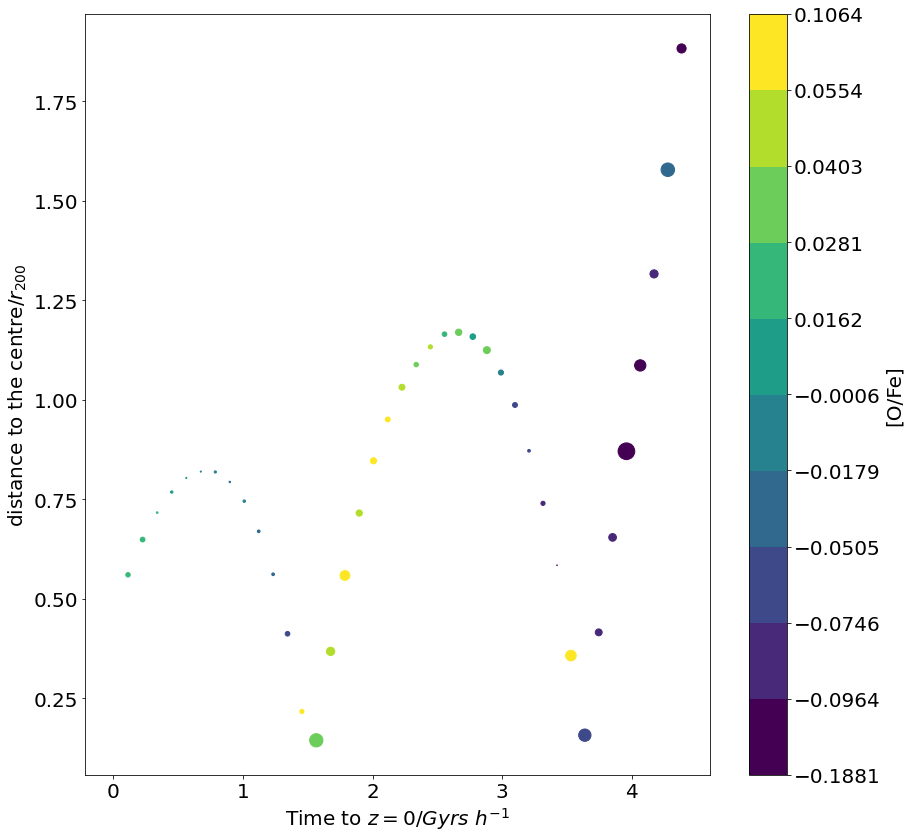

In [16]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4339, Gas_4339 = FeH, Gas
OFe_4339 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


25 25


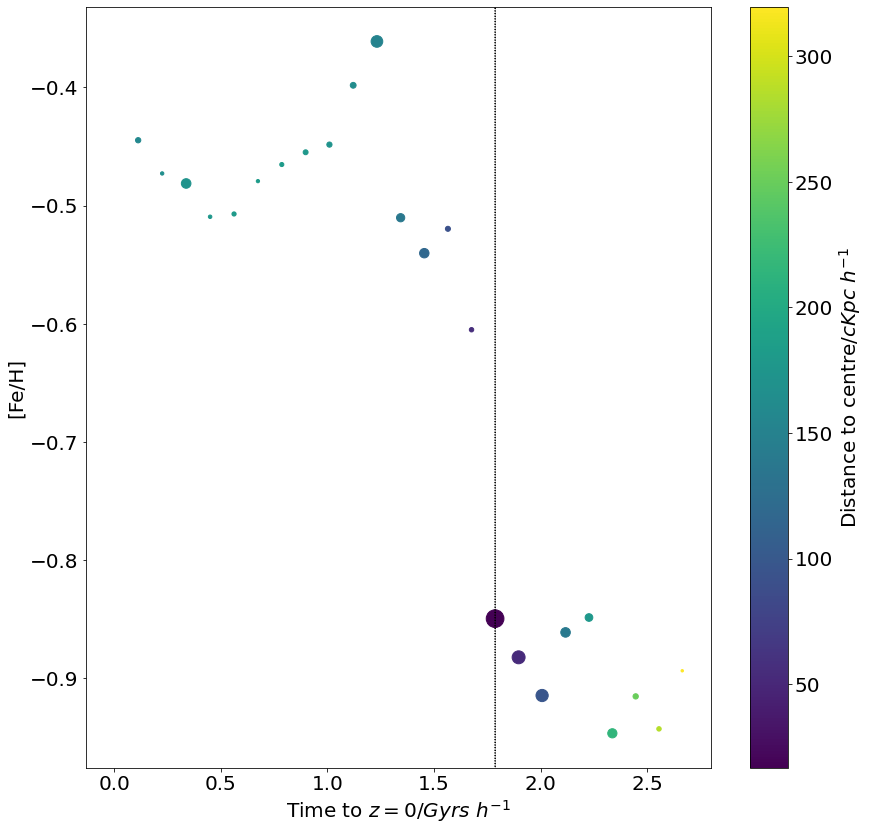

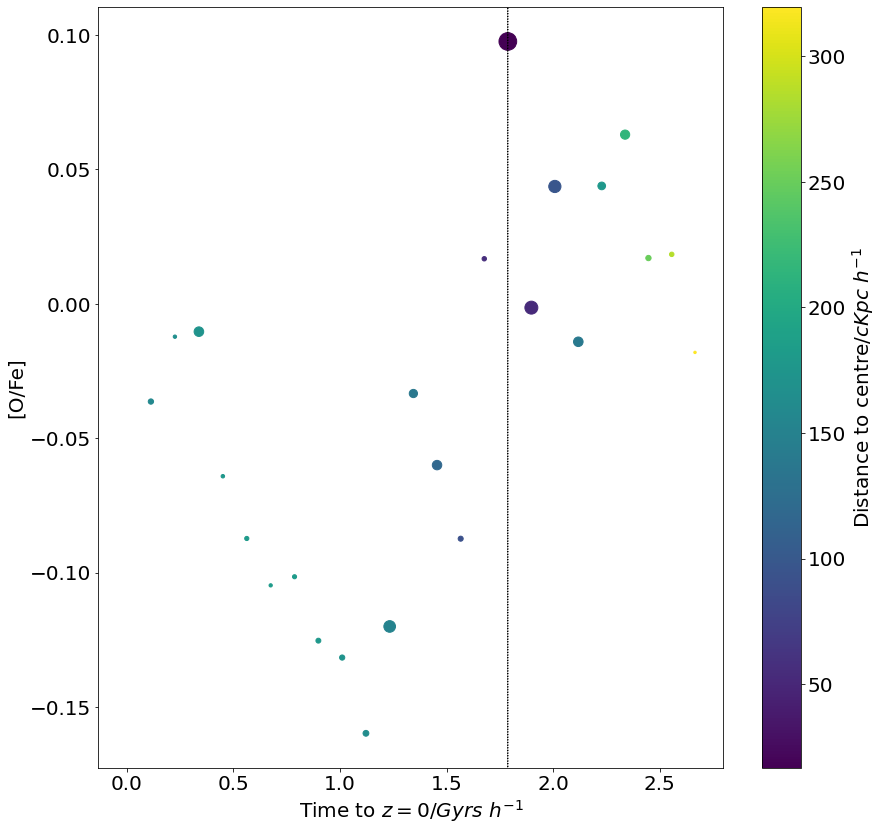

In [17]:
# ok, lets test this
gal, cen = 4341, 4337
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

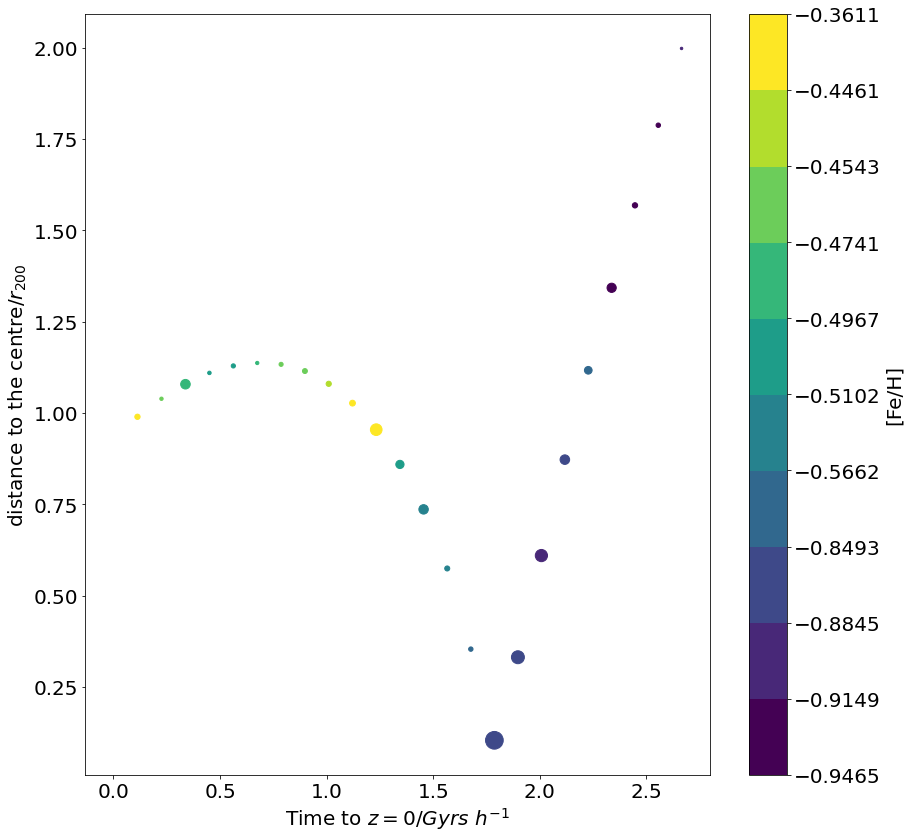

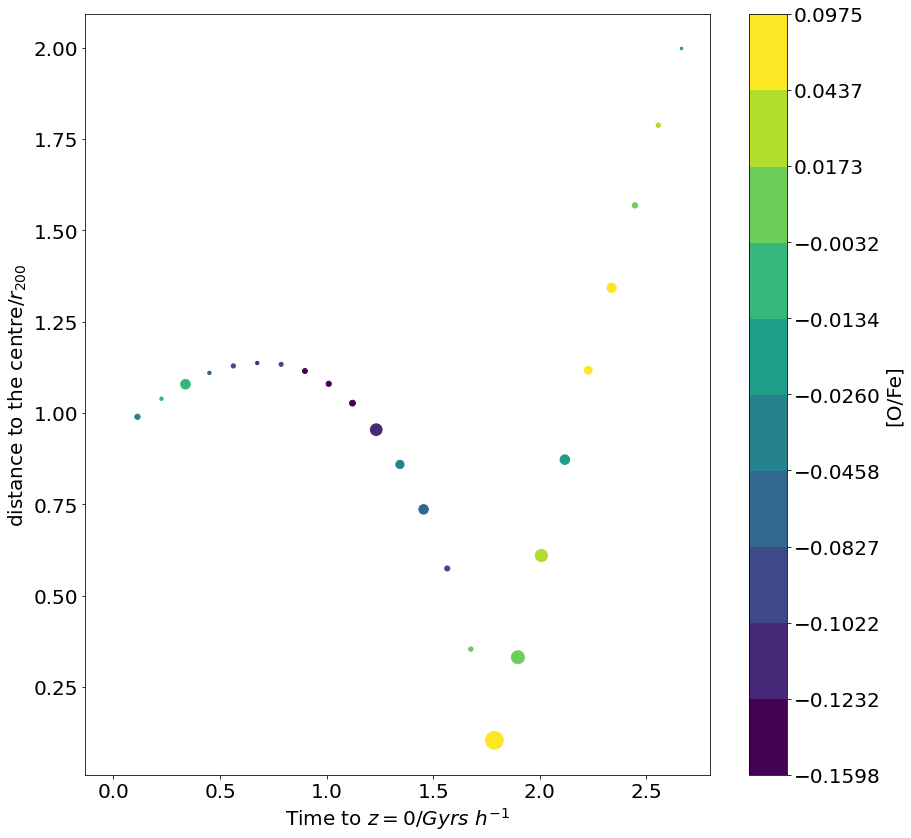

In [18]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4341, Gas_4341 = FeH, Gas
OFe_4341 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


45 45


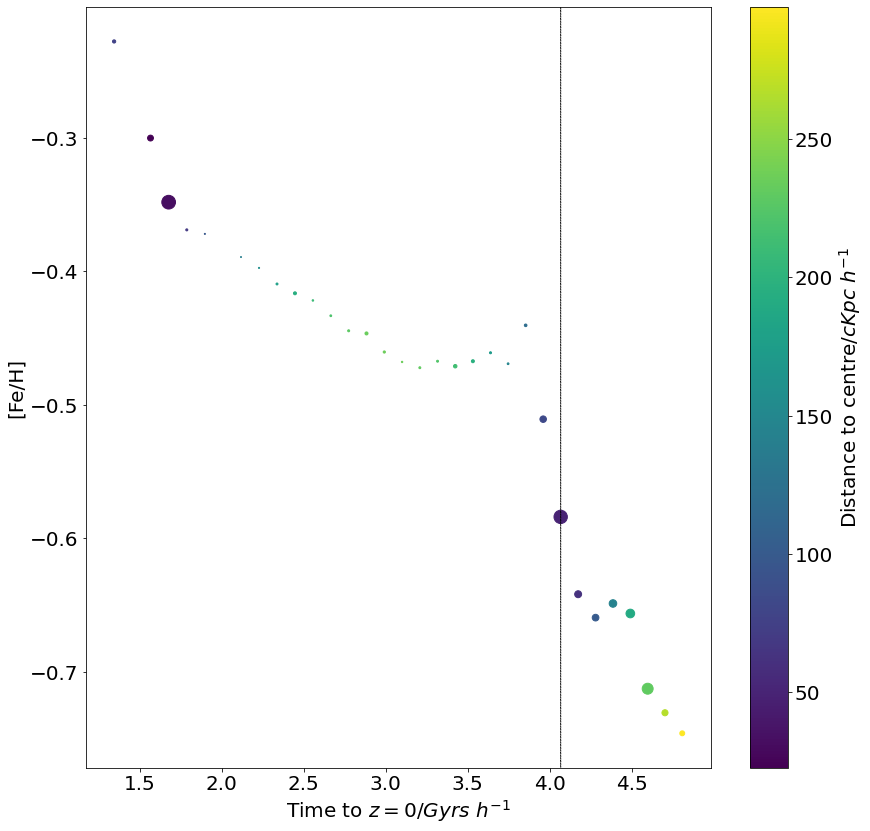

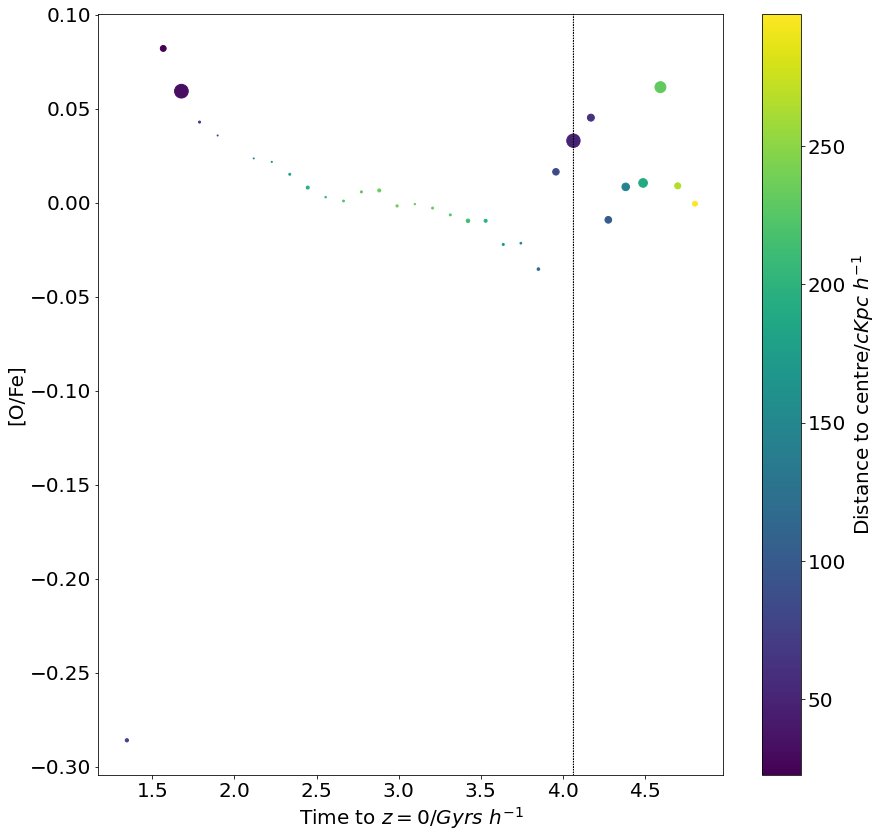

In [19]:
# ok, lets test this
gal, cen = 4343, 4337
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

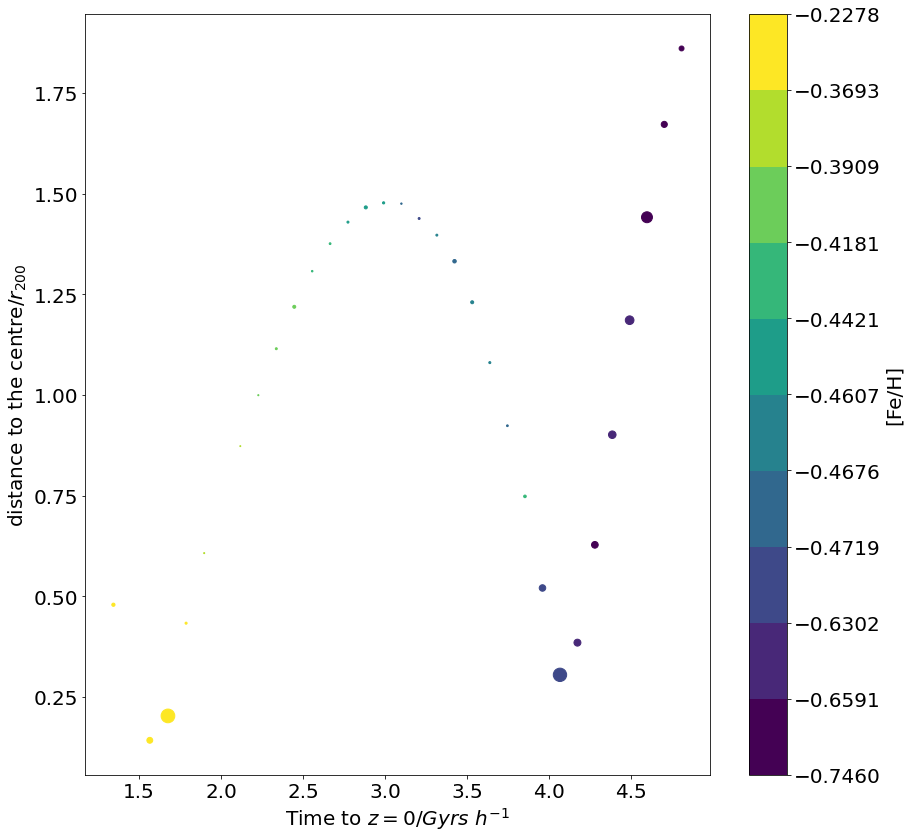

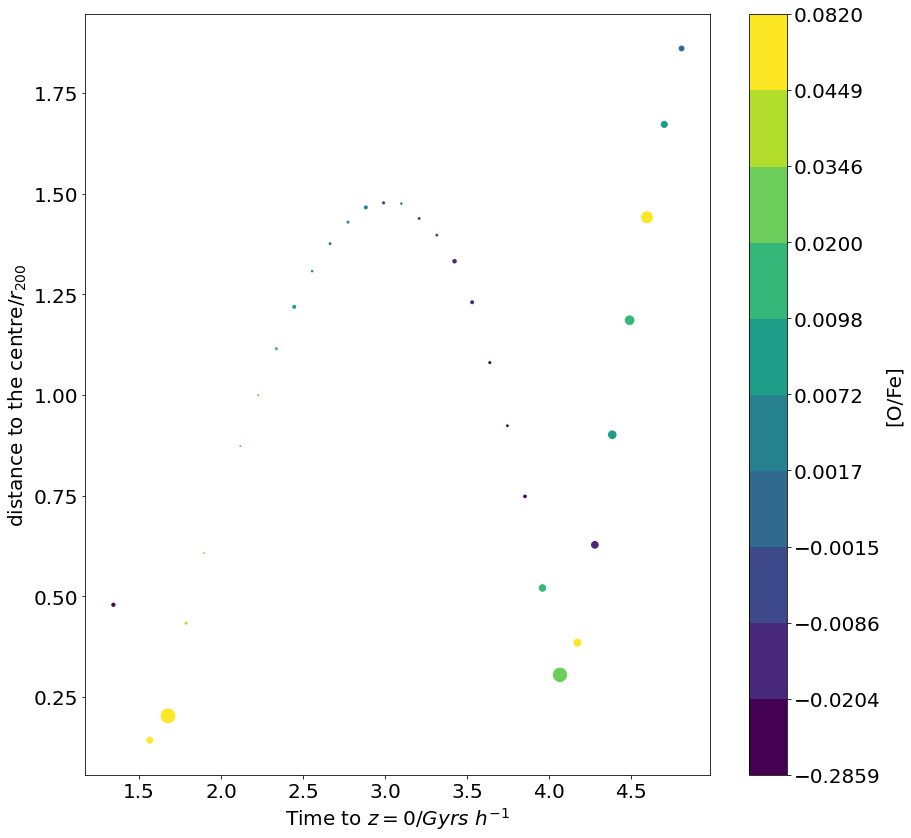

In [20]:
pl.figure(figsize=(14,14))

ii = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))[0]

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH[ii], vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

ii = np.where((np.isnan(OFe)==False) & (np.isinf(OFe)==False))[0]

papels3 = np.percentile(OFe[ii], vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4343, Gas_4343 = FeH, Gas
OFe_4343 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


36 36


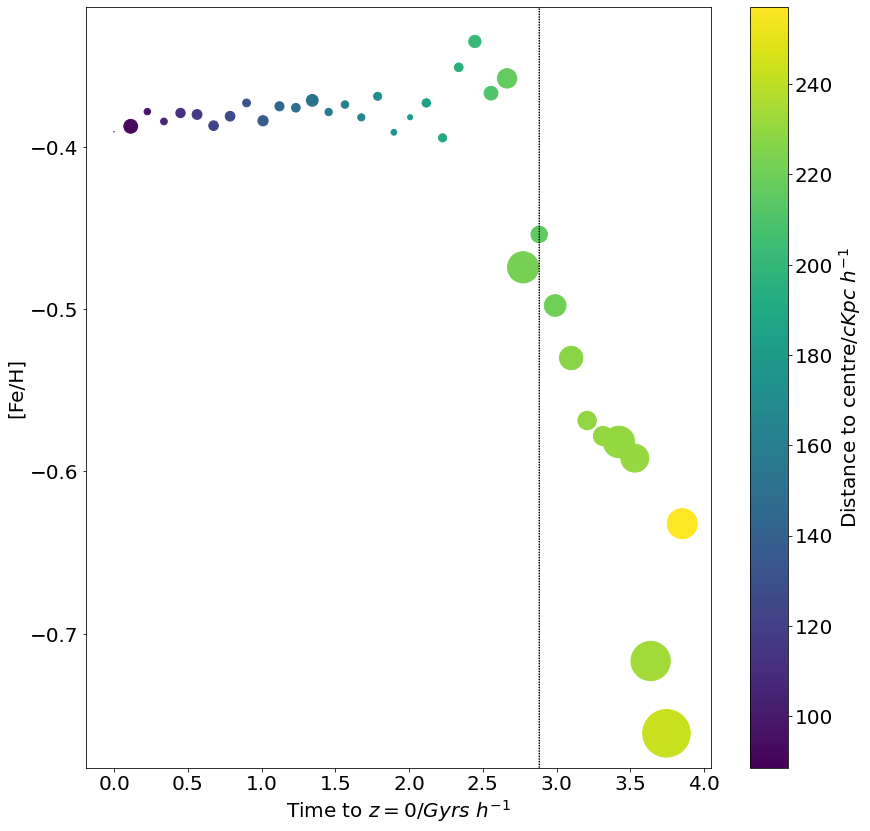

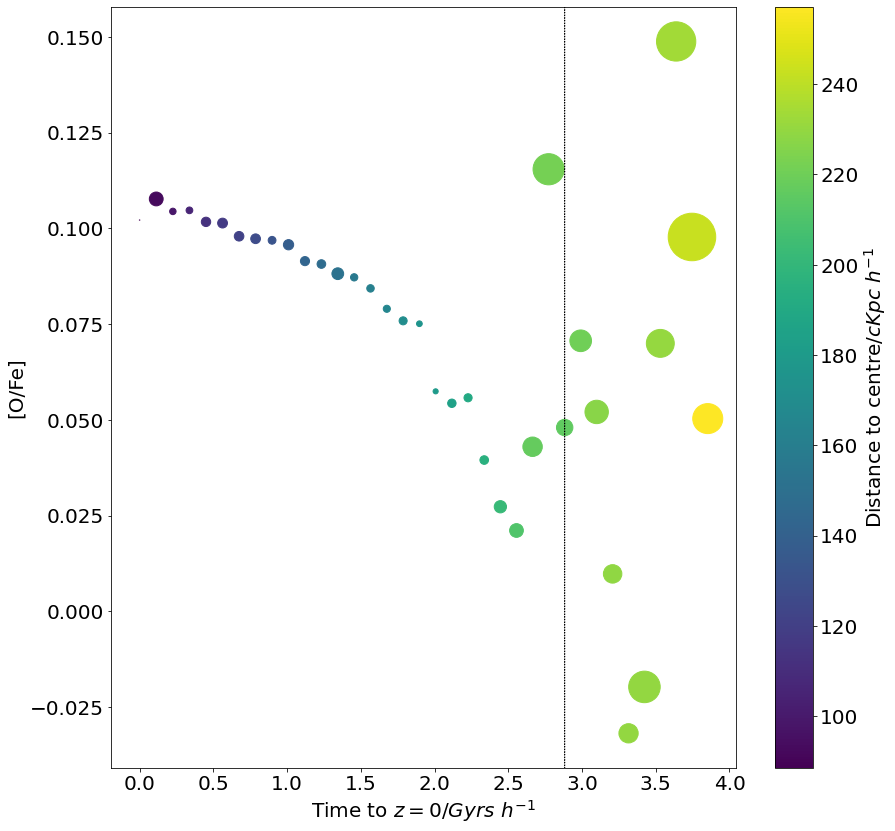

In [21]:
# ok, lets test this
gal, cen = 4470, 4469
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

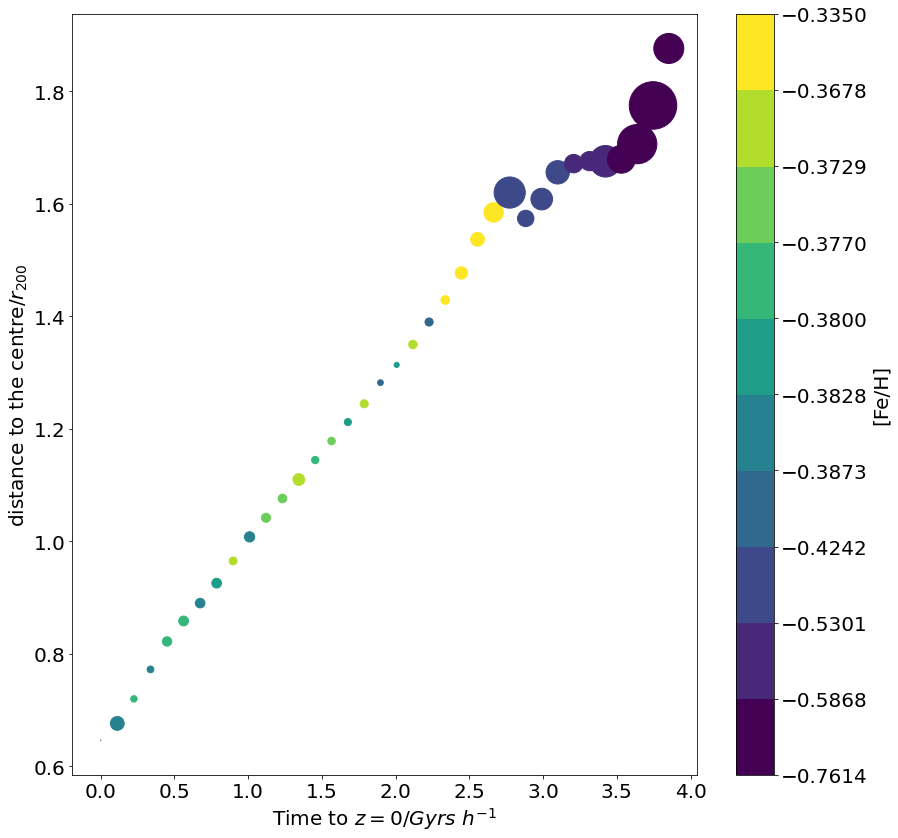

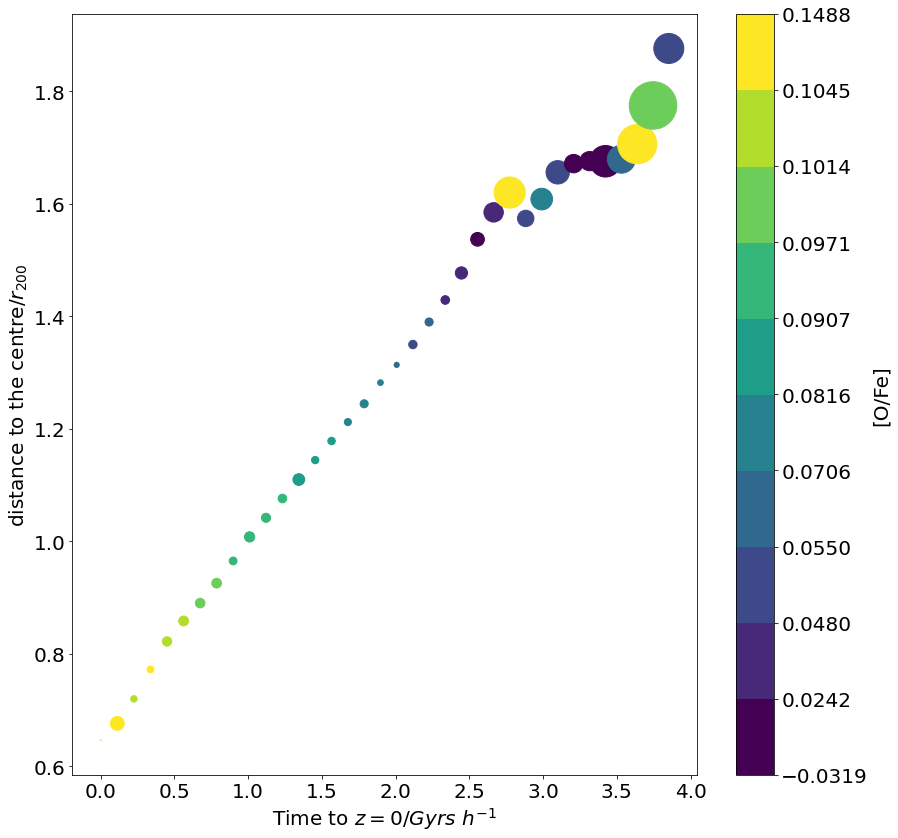

In [22]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4470, Gas_4470 = FeH, Gas
OFe_4470 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


34 34


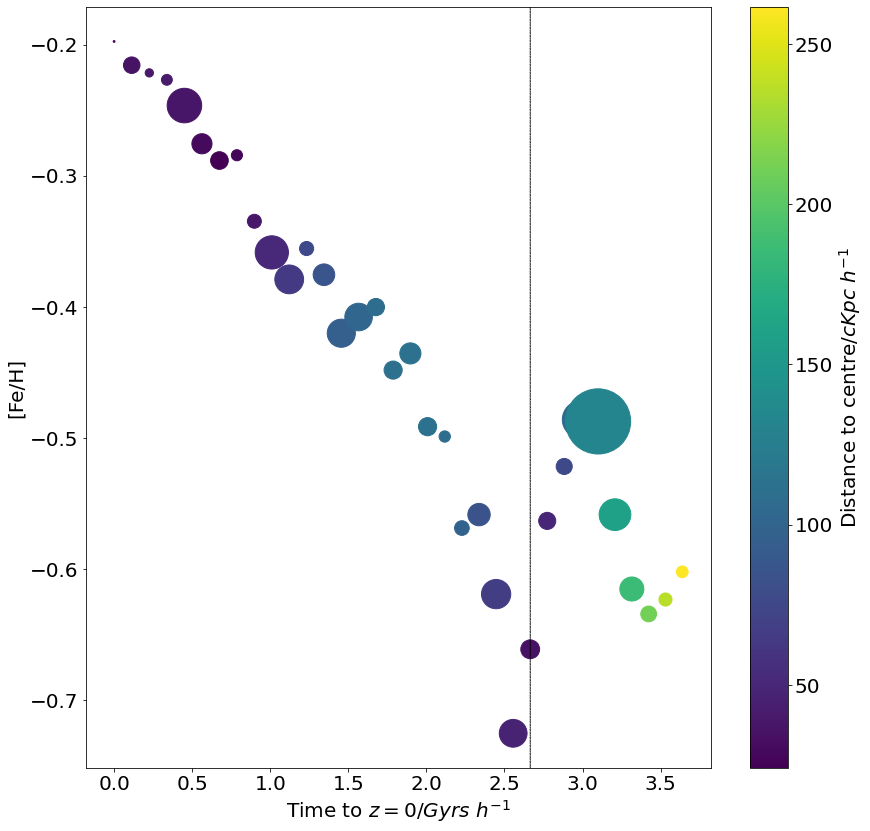

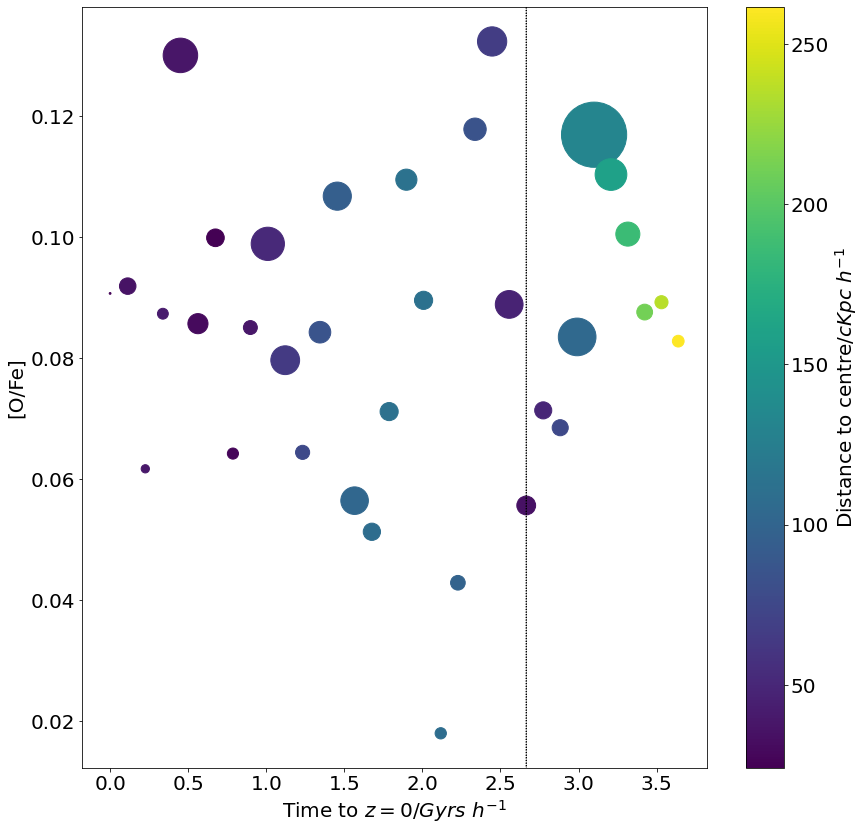

In [23]:
# ok, lets test this
gal, cen = 4471, 4469
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

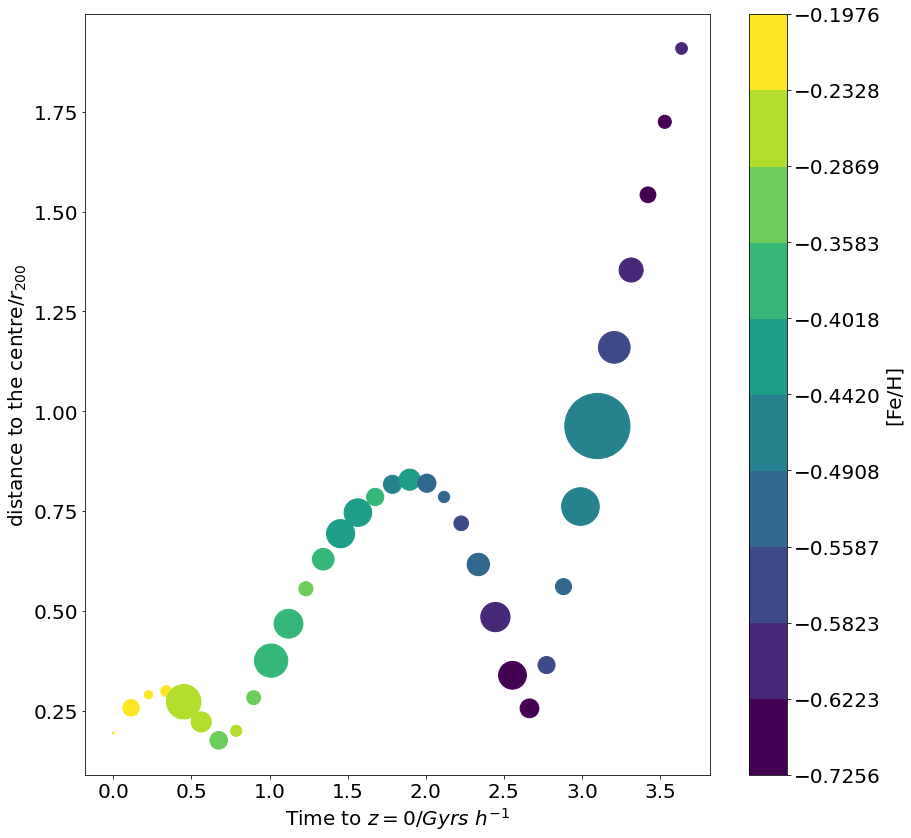

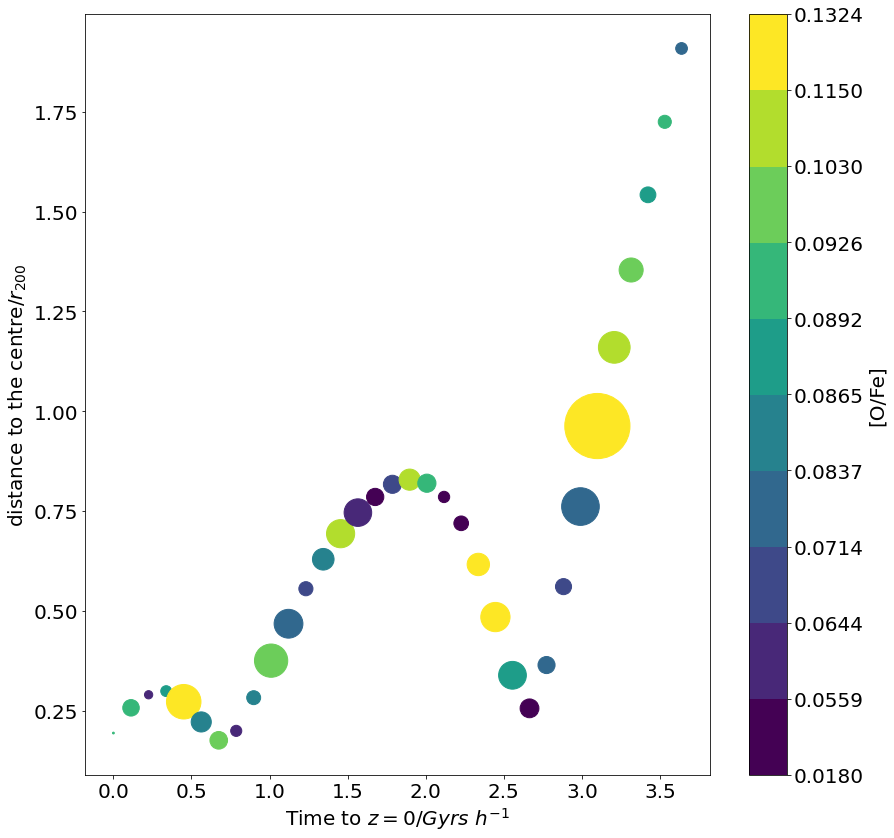

In [24]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4471, Gas_4471 = FeH, Gas
OFe_4471 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


21 21


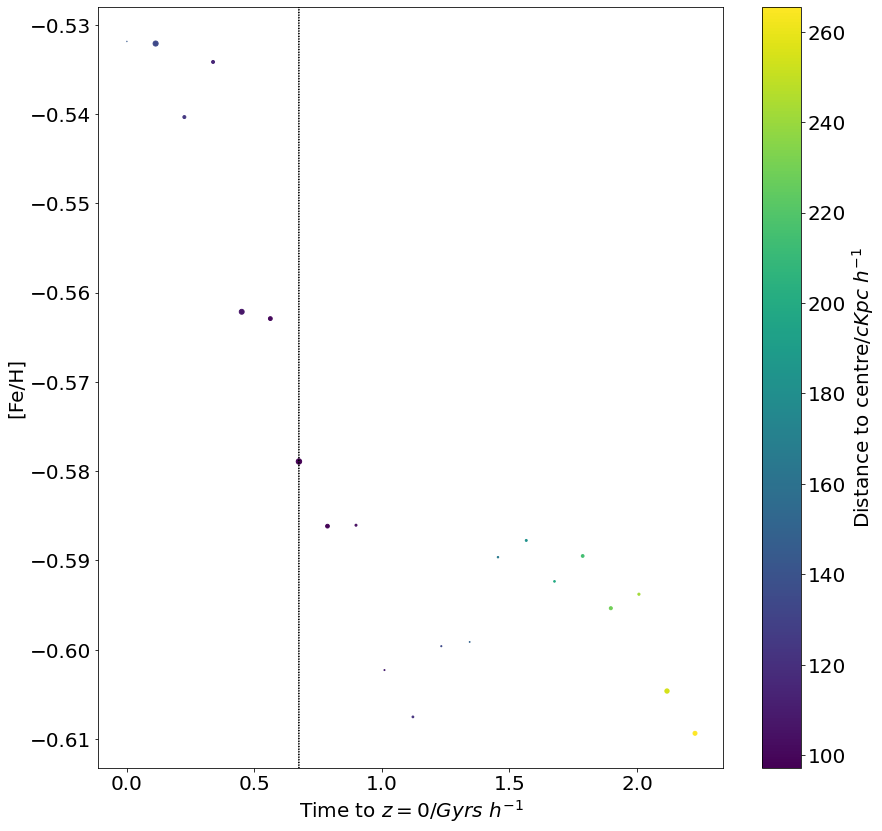

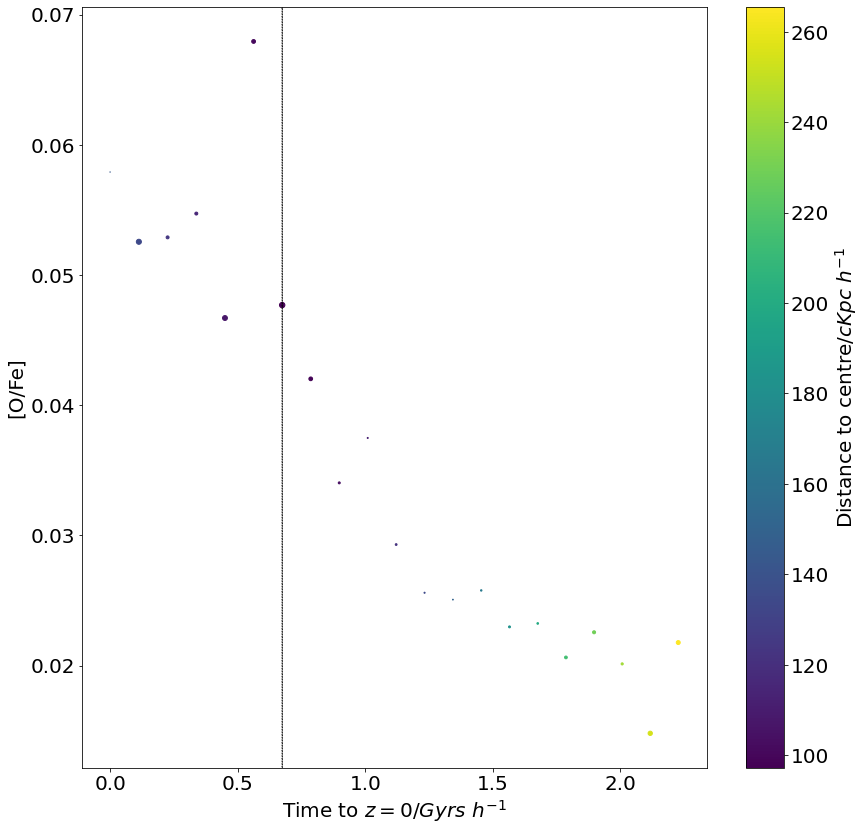

In [25]:
# ok, lets test this
gal, cen = 4473, 4469
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

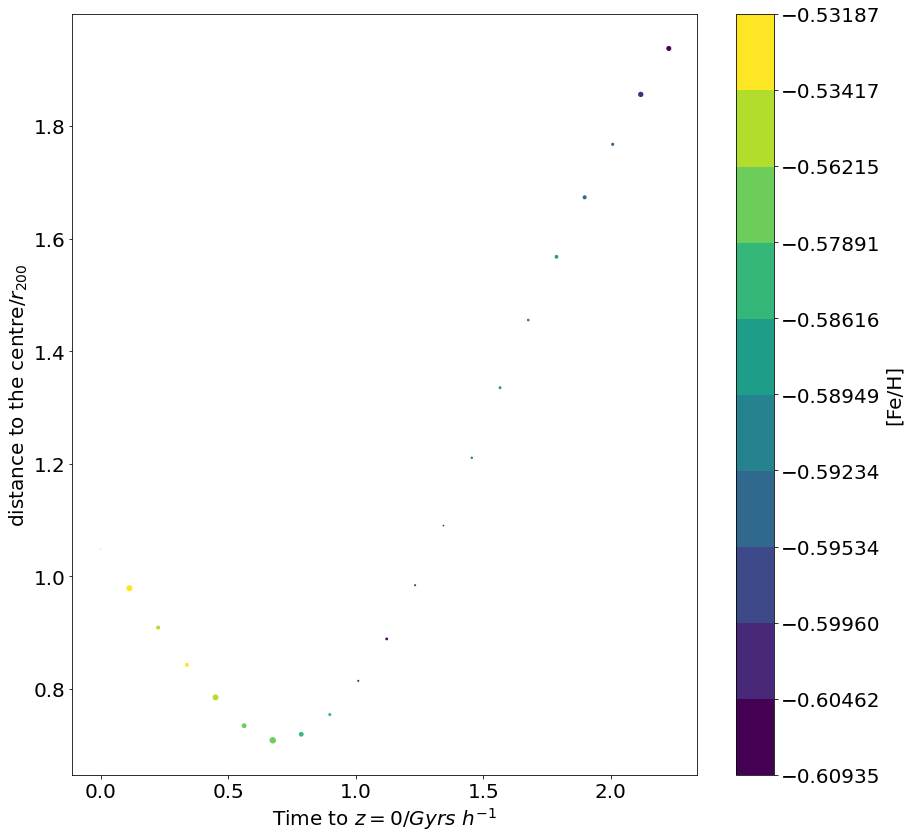

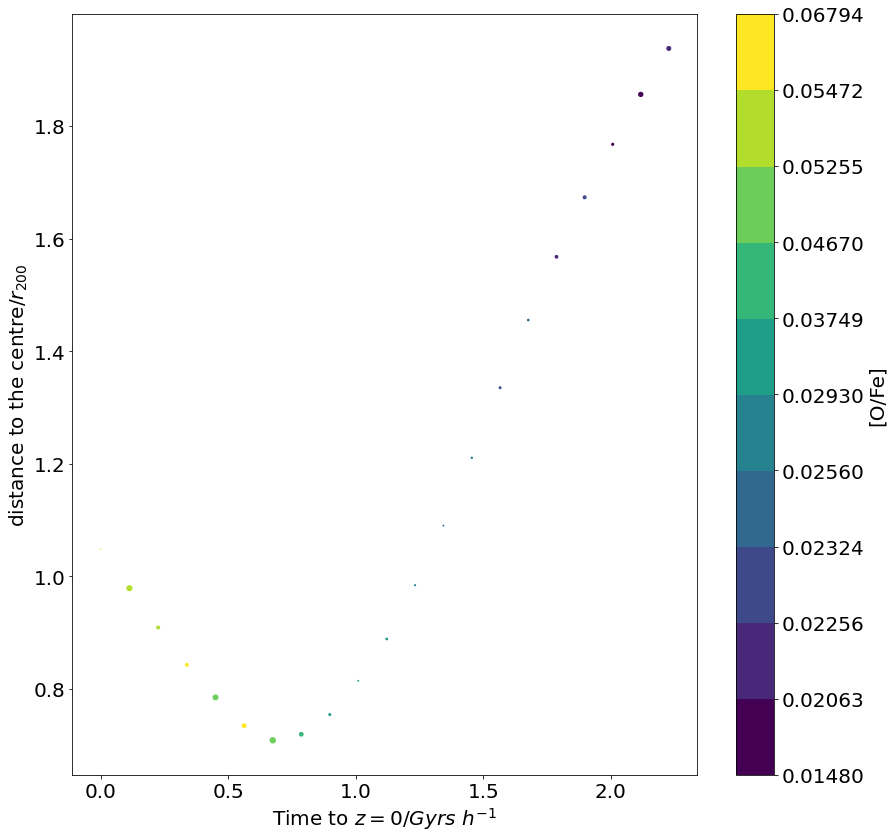

In [26]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4473, Gas_4473 = FeH, Gas
OFe_4473 = OFe

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


32 32


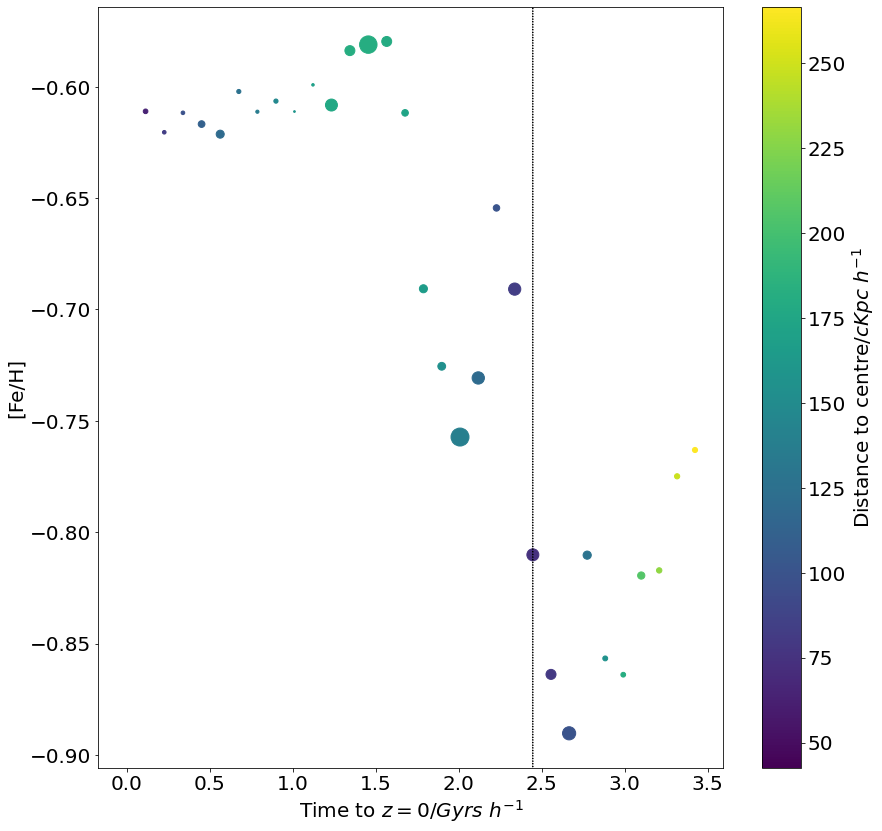

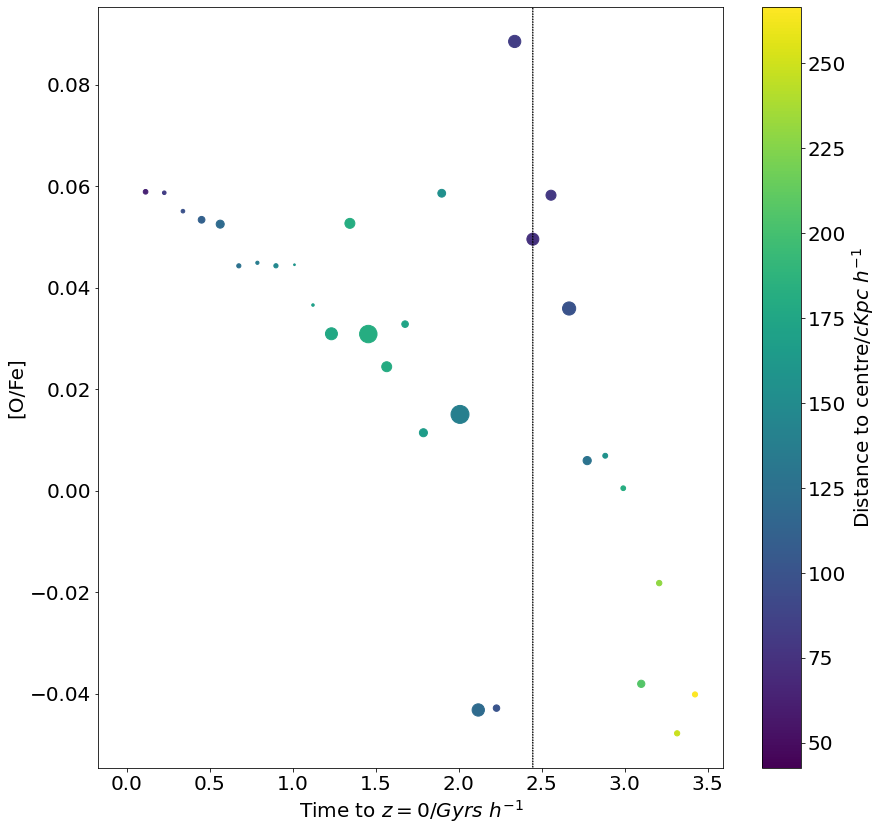

In [27]:
# ok, lets test this
gal, cen = 4474, 4469
z, FeH, OFe, dist, Gas = getMetTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, FeH, OFe, dist, Gas, Time = z[ii], FeH[ii], OFe[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, FeH, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[Fe/H]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

pl.scatter(Time, OFe, marker='o', c=dist, s=Gas/5e5)

pl.ylabel('[O/Fe]')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000, 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

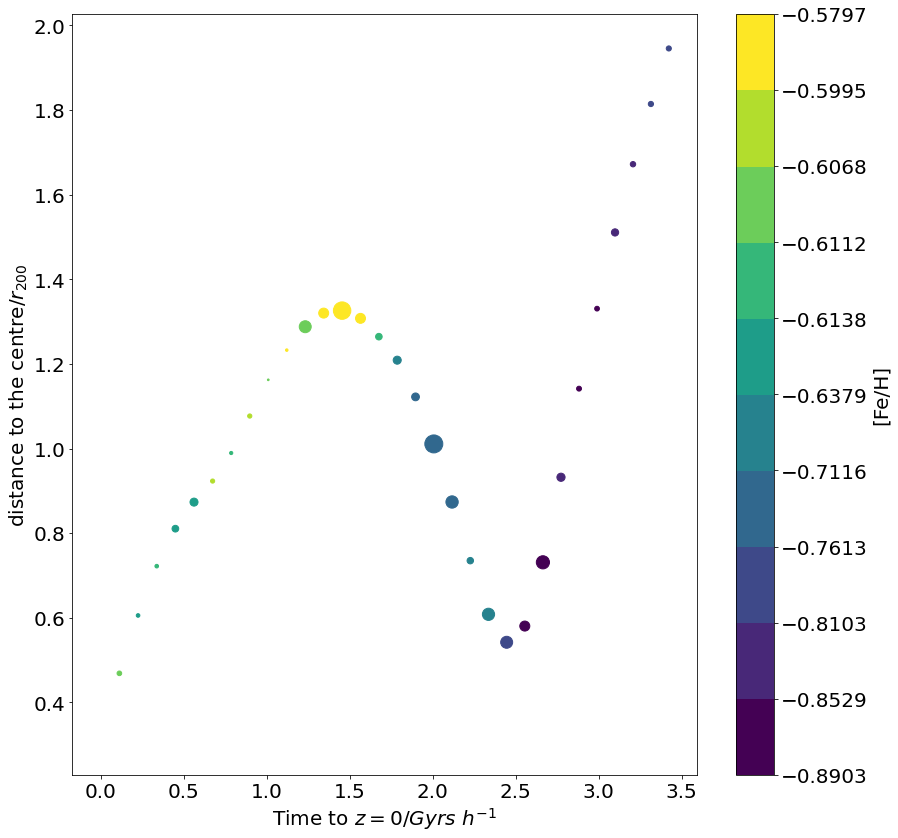

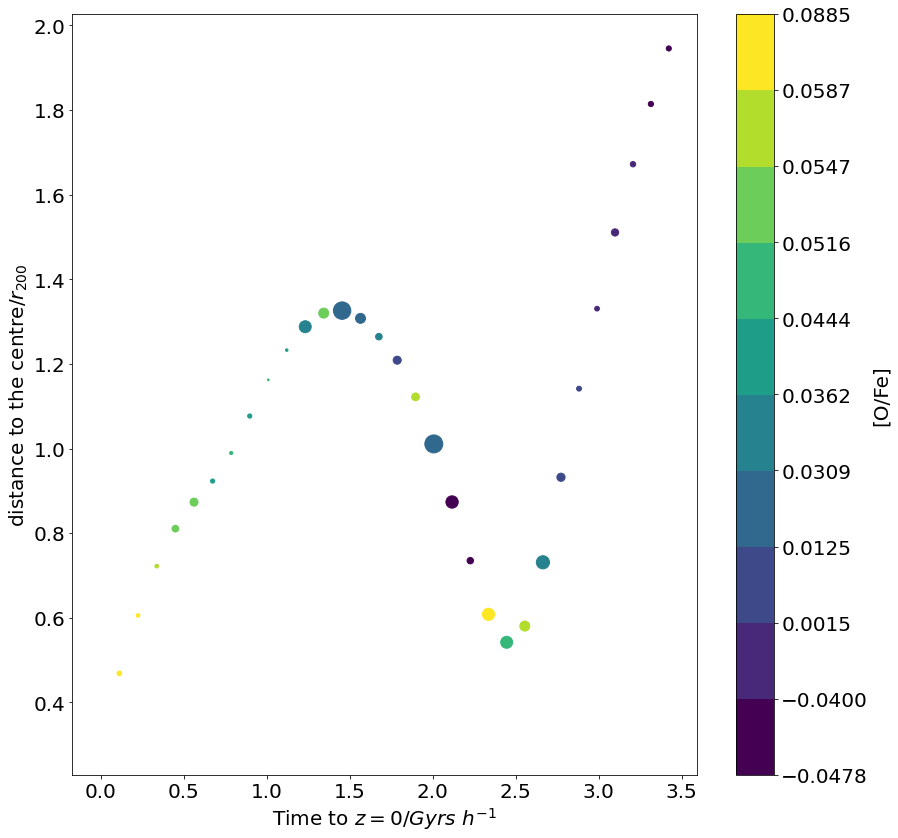

In [28]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(FeH, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=FeH, norm=norm2)

bar = pl.colorbar(label='[Fe/H]')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels3 = np.percentile(OFe, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=OFe, norm=norm3)

bar = pl.colorbar(label='[O/Fe]')
bar.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
FeH_4474, Gas_4474 = FeH, Gas
OFe_4474 = OFe

In [29]:
# gas density, ok, gas density.

def getDens(idd, iddC, snap):
    # get tidal form anything around , lets say I dont know, what i think is close
    # 200 kpc is almost the virial radius, so 100 kpc should be good, and the center always, obviously.
    
    optRadius = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
    offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offGas[0]:offGas[1]]
    rpart = np.sqrt((posPart[:,0] - posGal[0])**2+(posPart[:,1] - posGal[1])**2+(posPart[:,2] - posGal[2])**2)
    index = np.arange(offGas[0], offGas[1])
    ii = np.where(rpart<optRadius)[0]
    indexR = index[ii]
    
    Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][indexR]
    
    Vol = 4./3.*np.pi*optRadius**3
    TDens = np.sum(Mass)*1e10/Vol
    
    return TDens

In [30]:
def getDensTime(gal, central):
    
    z, Dens, snaplist, dist = [], [], [], []
    
    Idlist, snapst  = [], []
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        pos = np.sqrt(np.sum((galPos-groupPos)**2))
        
        if pos>2*r200:
            break
        
        tDens = getDens(idd, iddC, snap)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        snaplist.append(snap)
        Dens.append(tDens)
        dist.append(pos)
        
        # and now lost masses
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        z.append(zs)
        
    z, Dens, snaplist, dist = np.array(z), np.array(Dens), np.array(snaplist), np.array(dist)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return z, Dens, dist, Gas*1e10

In [31]:
# ok, lets test this
gal, cen = 4338, 4337
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

25 25


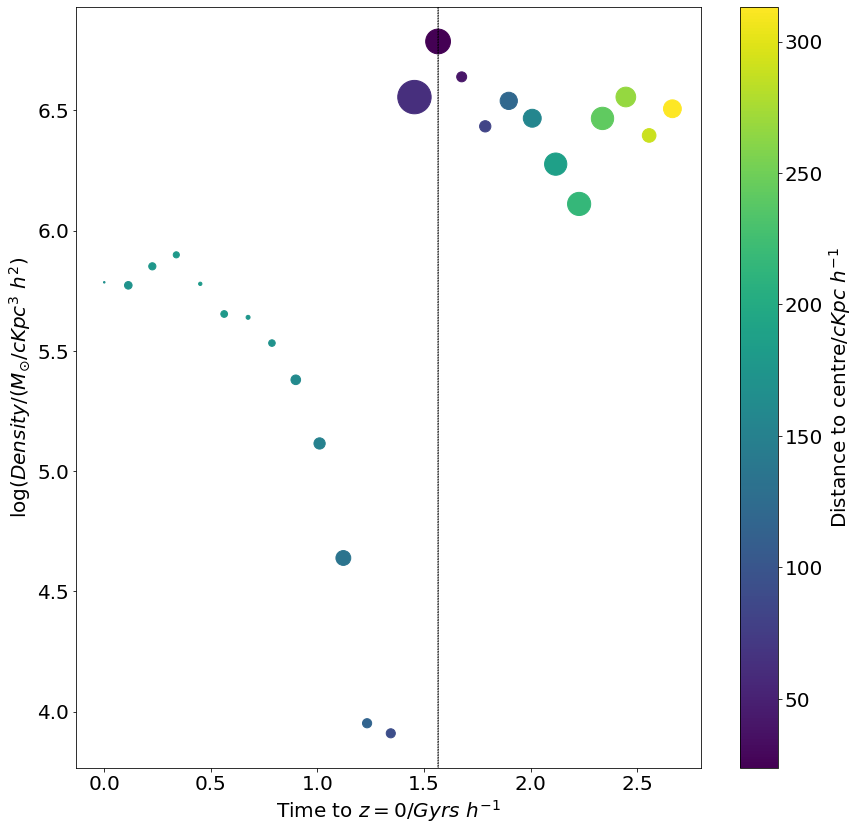

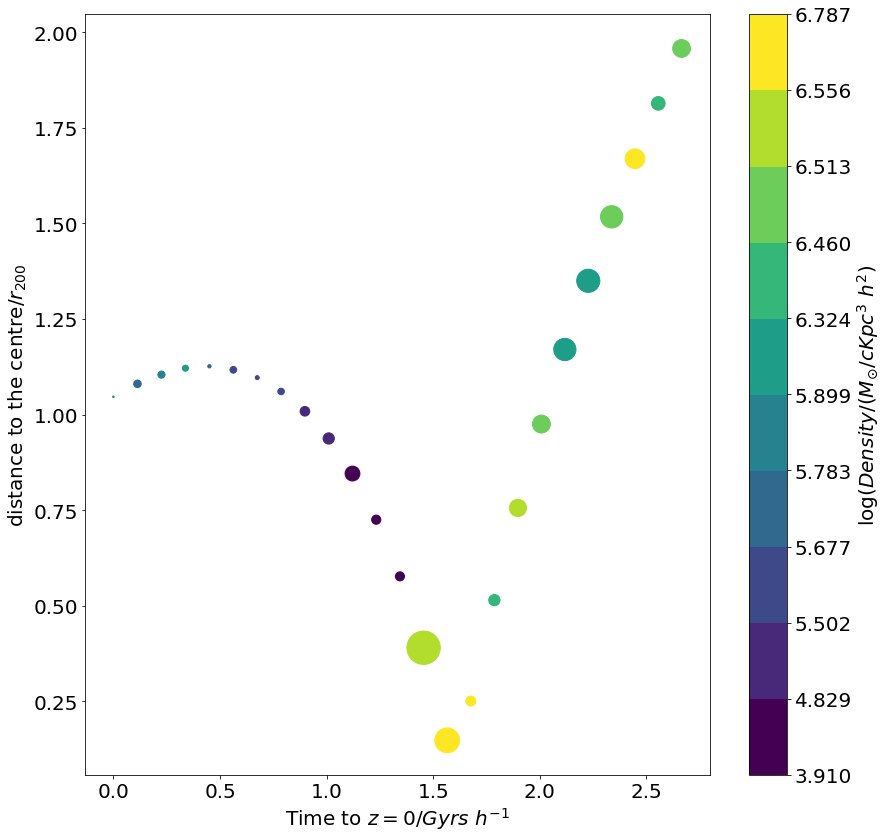

In [32]:
pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4338 = Dens

41 41


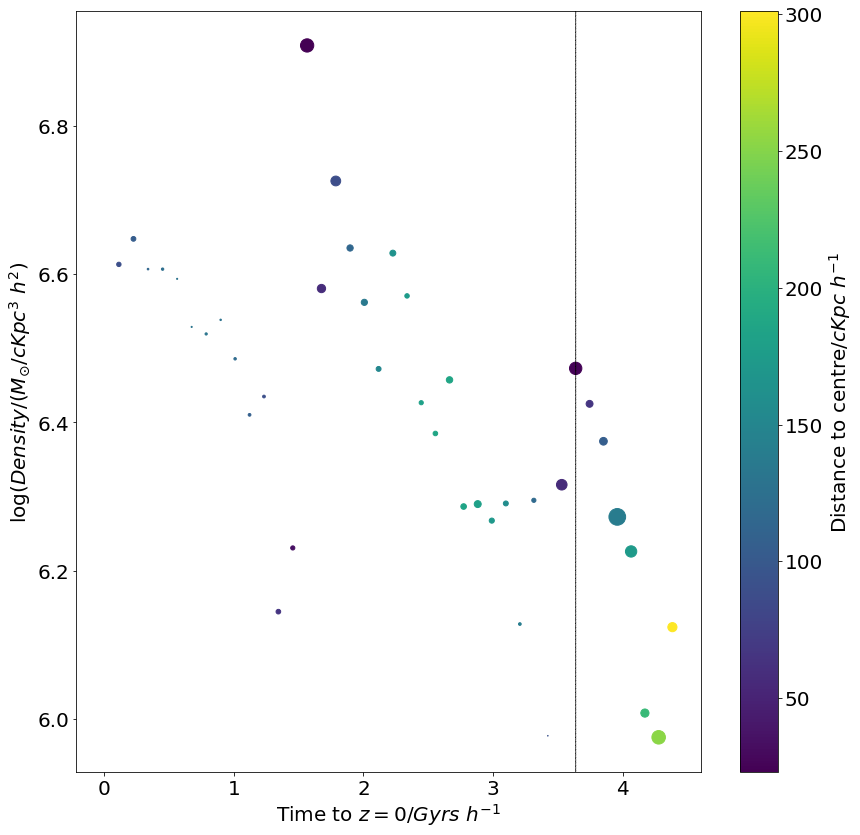

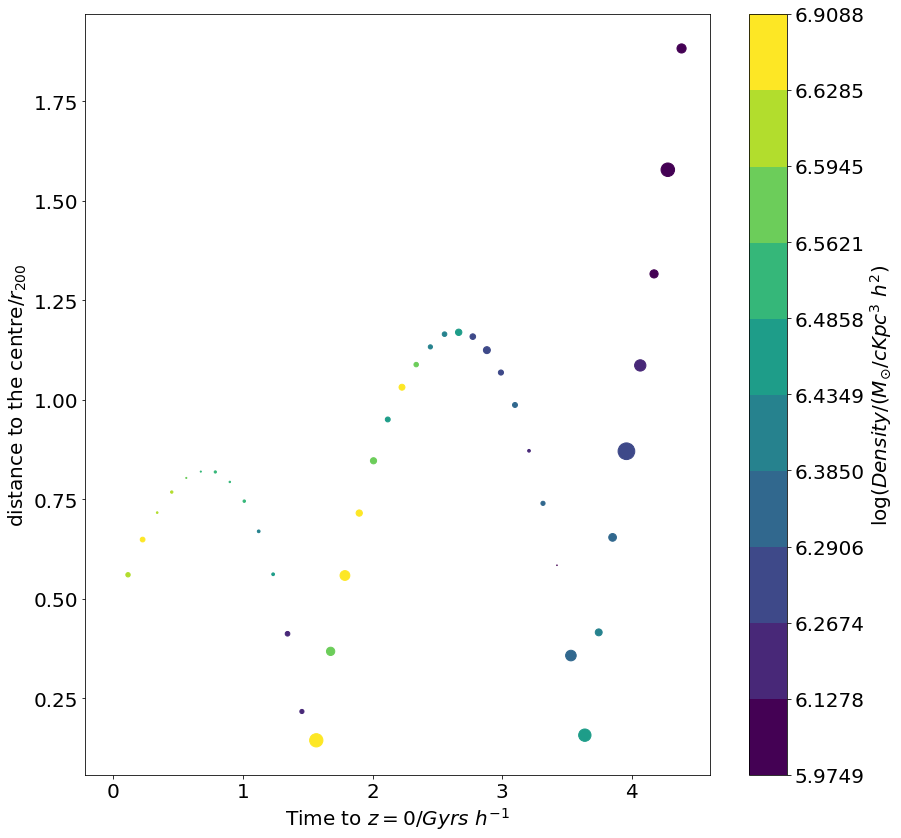

In [33]:
# ok, lets test this
gal, cen = 4339, 4337
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4339 = Dens

25 25


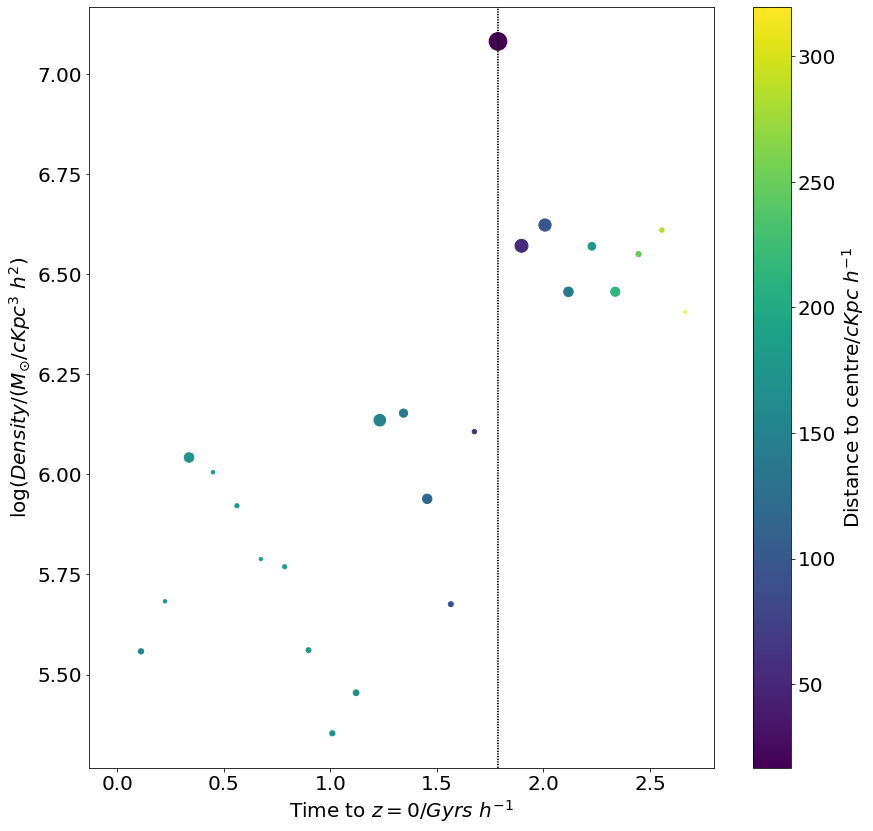

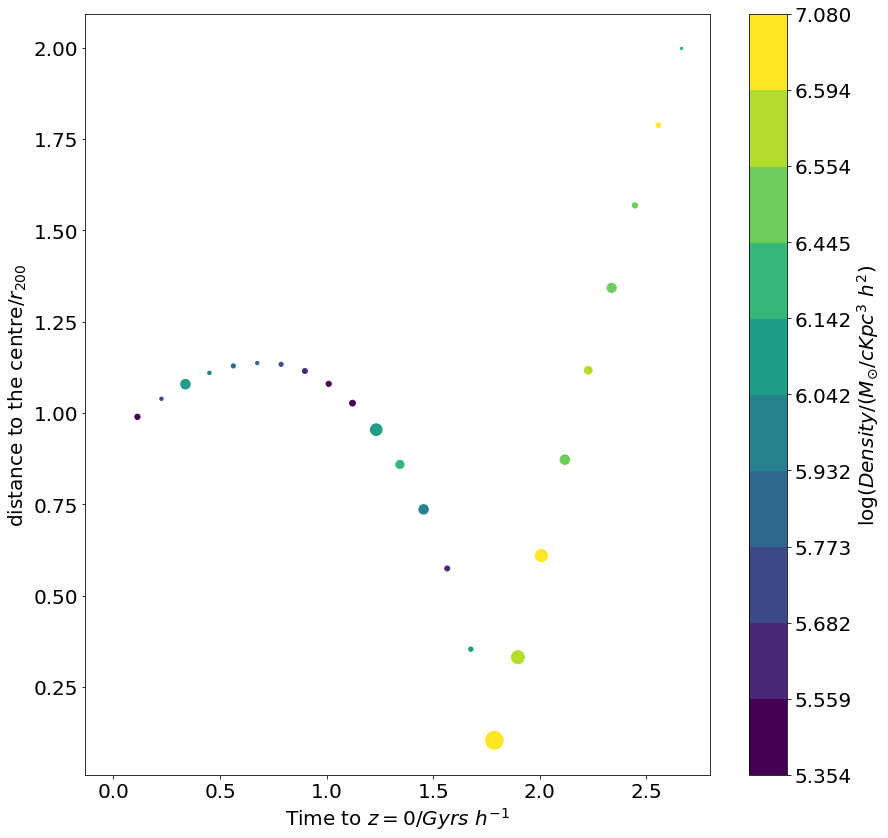

In [34]:
gal, cen = 4341, 4337
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4341 = Dens

45 45


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


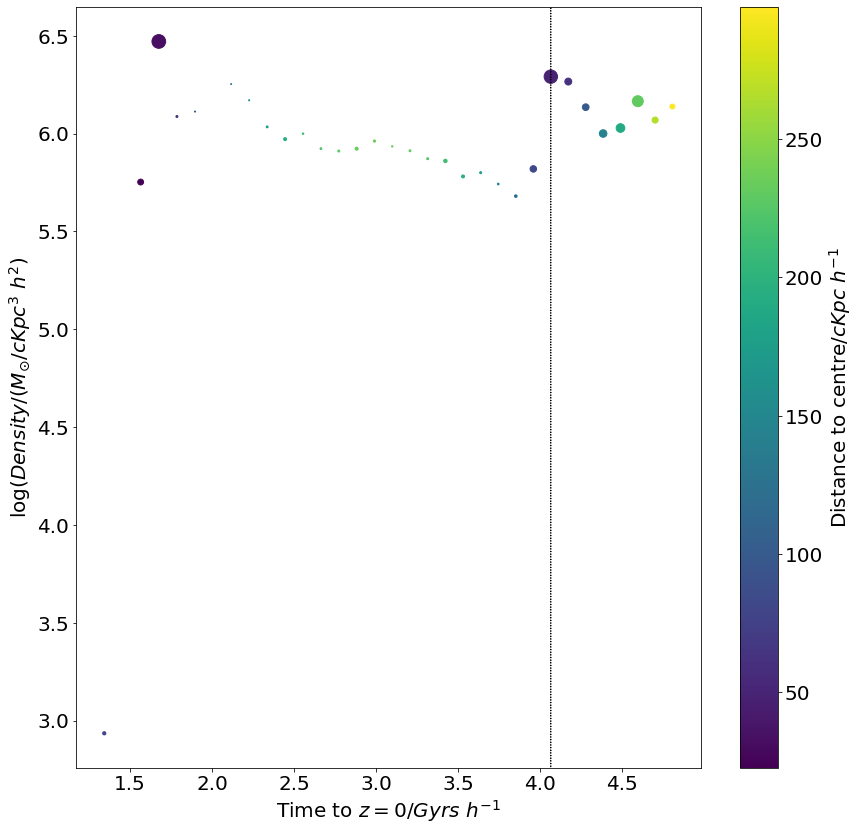

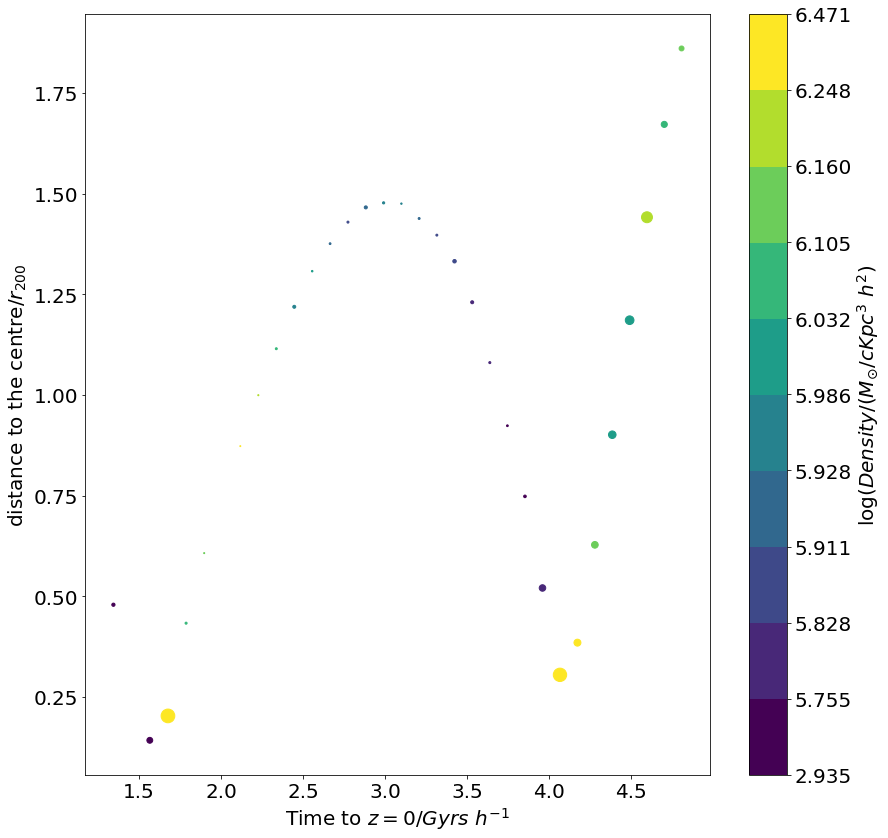

In [35]:
gal, cen = 4343, 4337
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

ii = np.where((np.isnan(np.log10(Dens))==False) & (np.isinf(np.log10(Dens))==False))[0]

papels4 = np.percentile(np.log10(Dens[ii]), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4343 = Dens

36 36


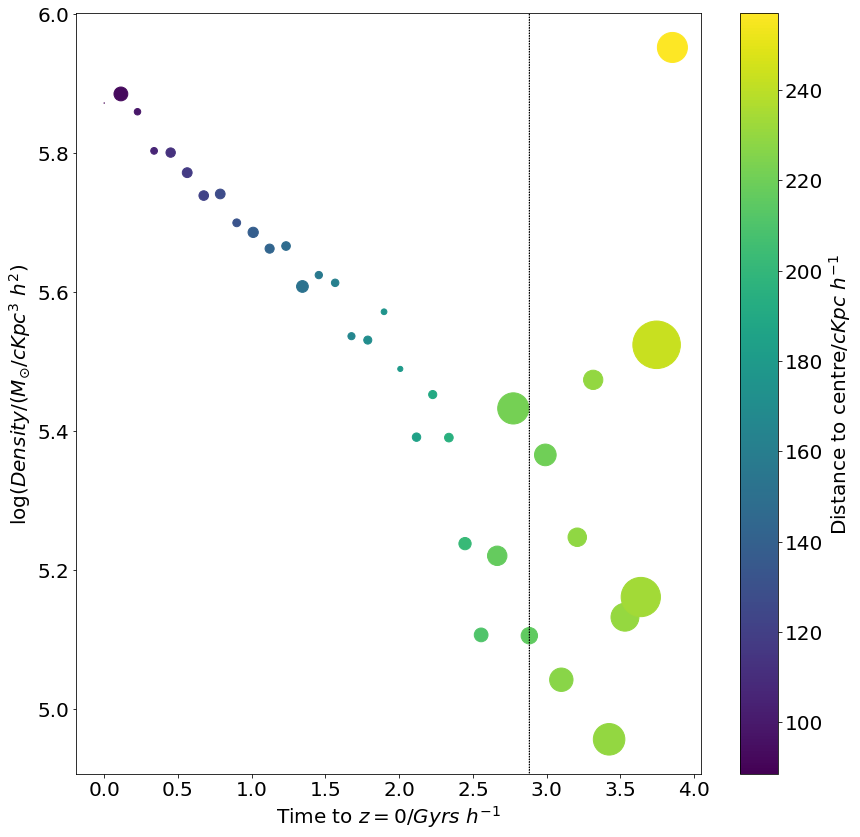

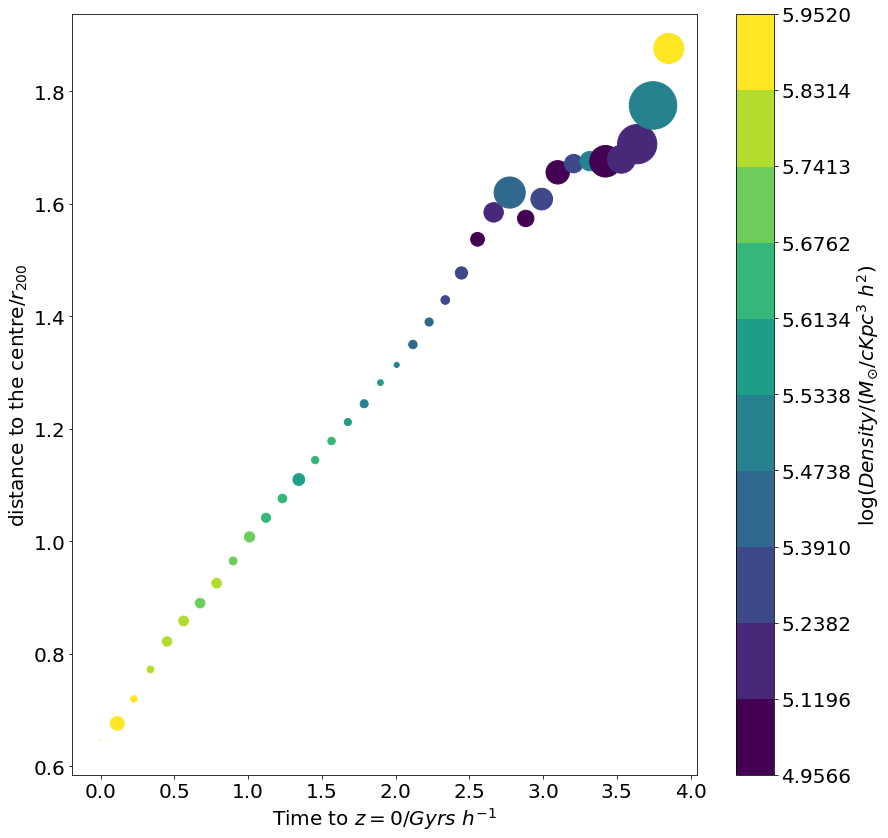

In [36]:
gal, cen = 4470, 4469
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4470 = Dens

34 34


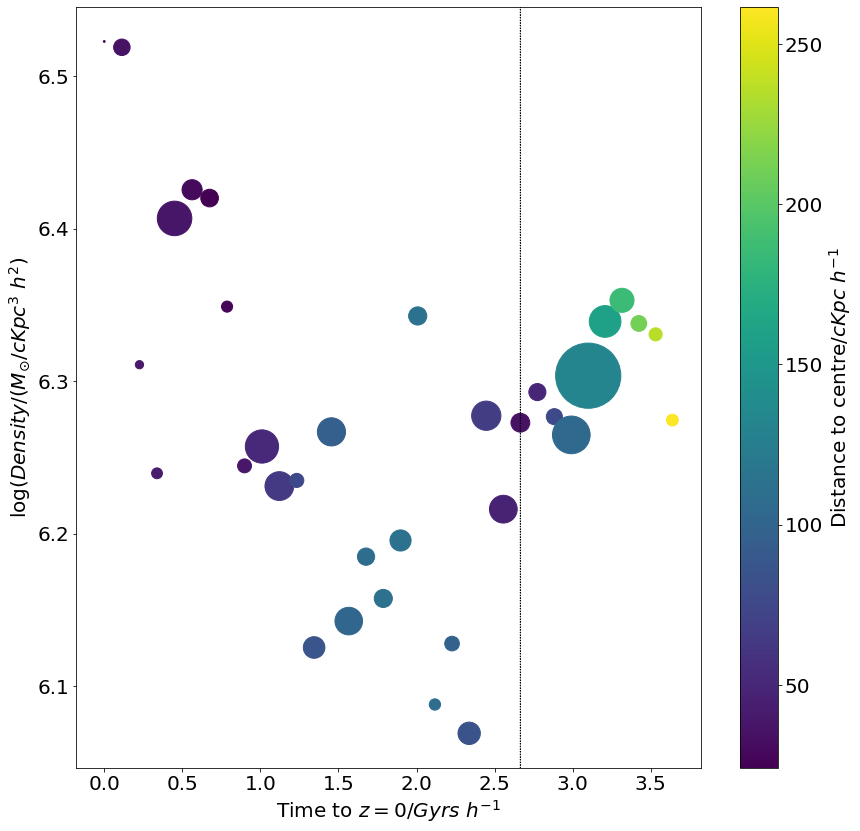

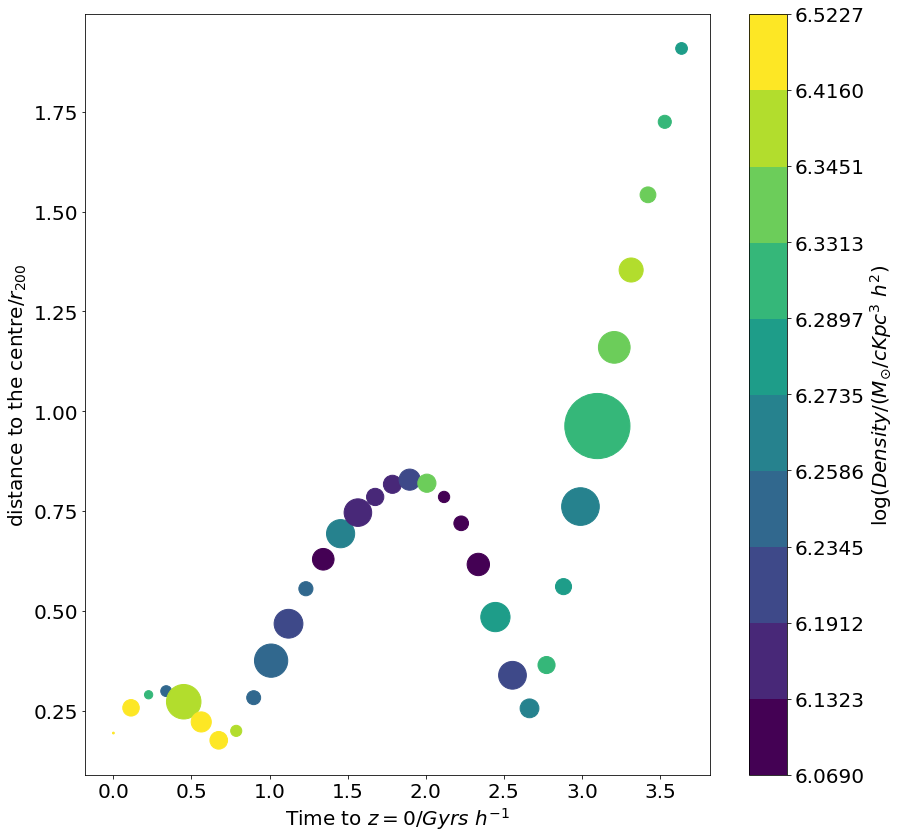

In [37]:
gal, cen = 4471, 4469
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4471 = Dens

21 21


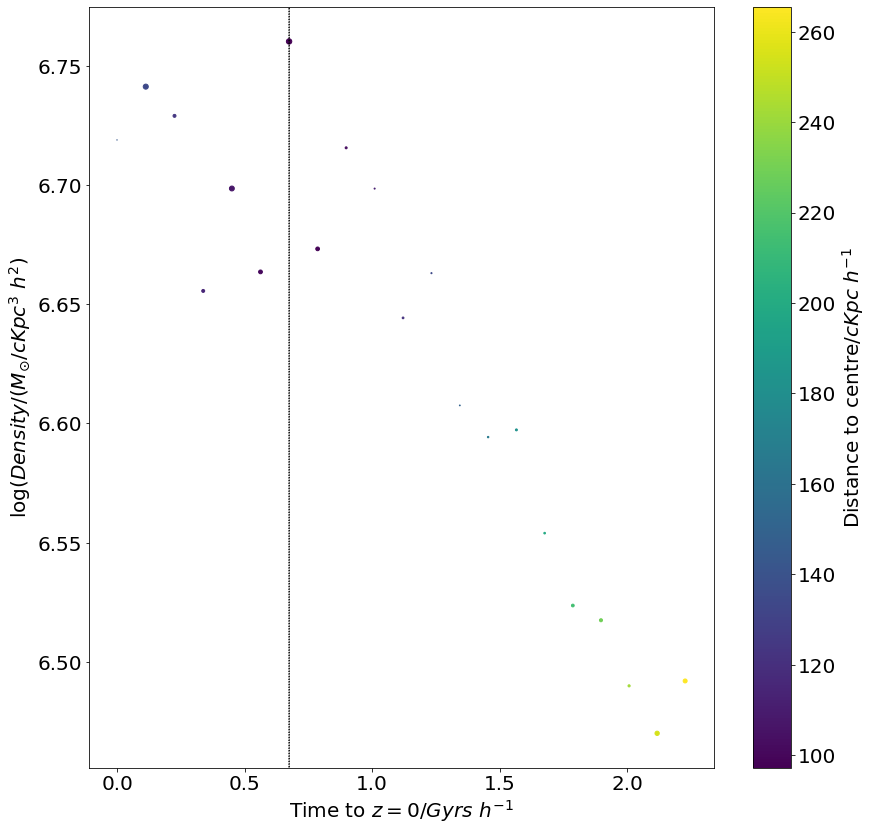

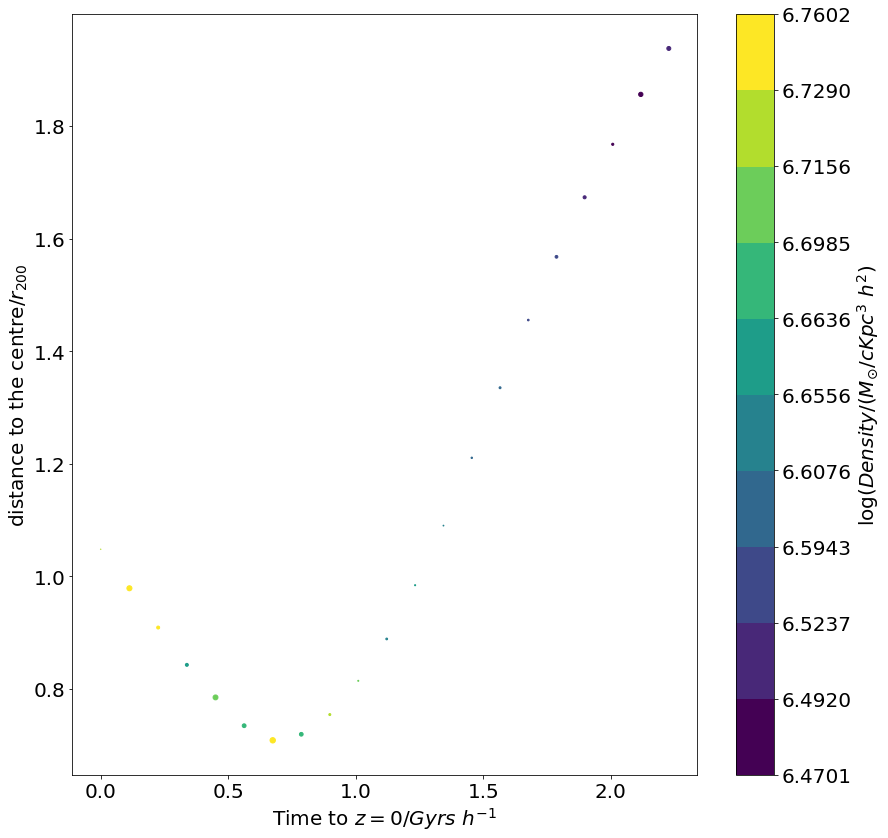

In [38]:
gal, cen = 4473, 4469
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4473 = Dens

32 32


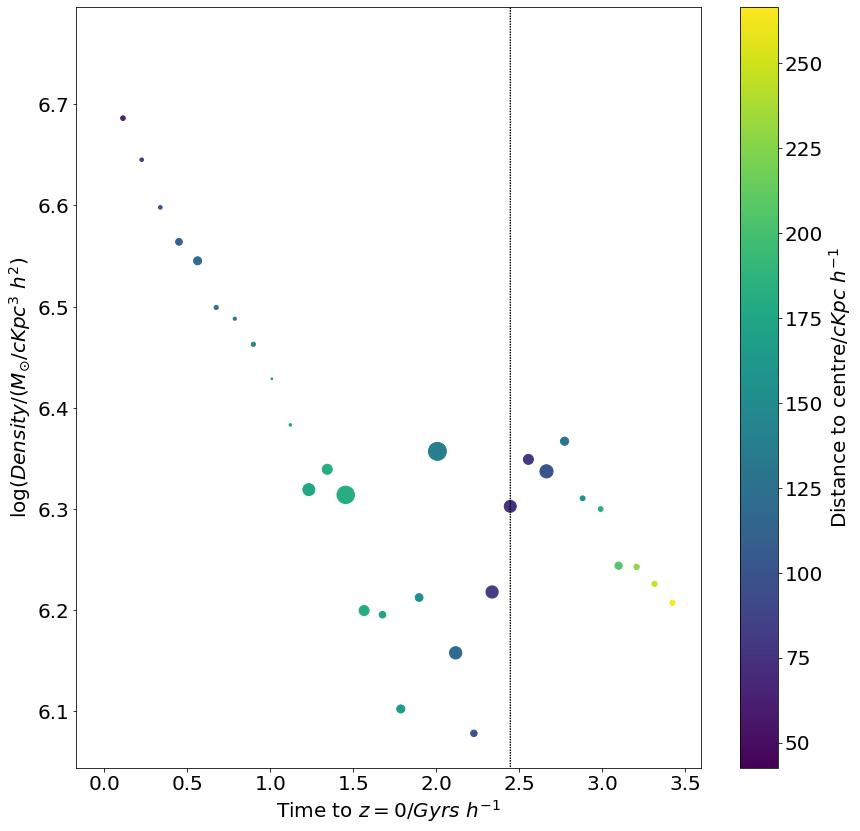

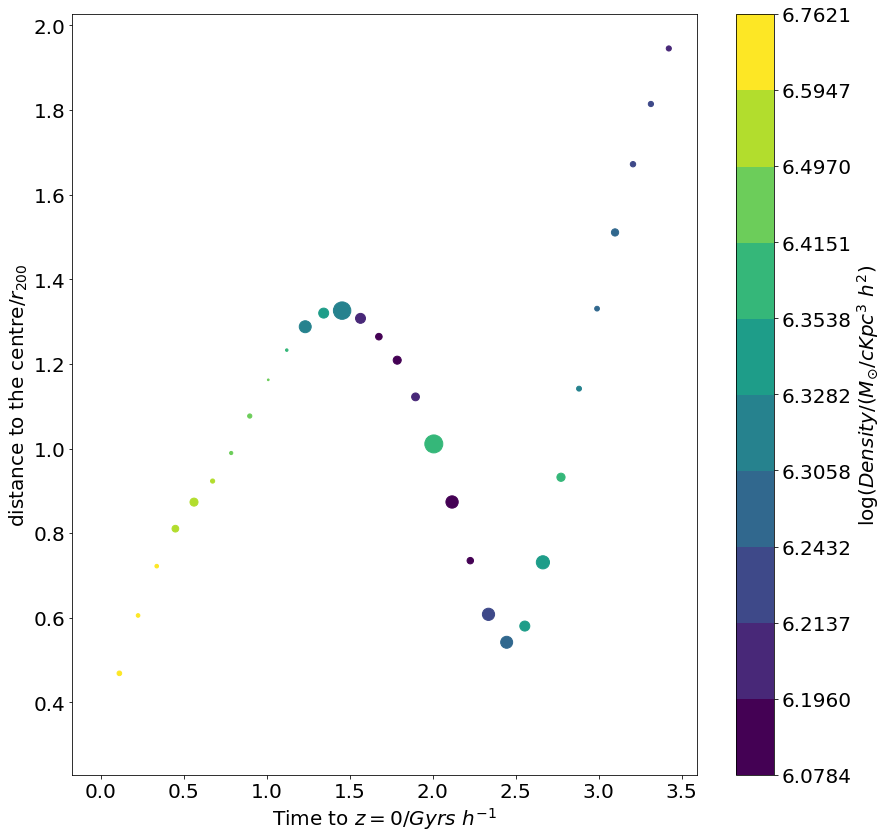

In [39]:
gal, cen = 4474, 4469
z, Dens, dist, Gas = getDensTime(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, Dens, dist, Gas, Time = z[ii], Dens[ii], dist[ii], Gas[ii], Time[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(Dens), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, -1000., 0, 2000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

papels4 = np.percentile(np.log10(Dens), vaper)
norm4 = mpc.BoundaryNorm(boundaries=papels4, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(Dens), norm=norm4)

bar = pl.colorbar(label='$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
bar.set_ticks(papels4)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Dens_4474 = Dens

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

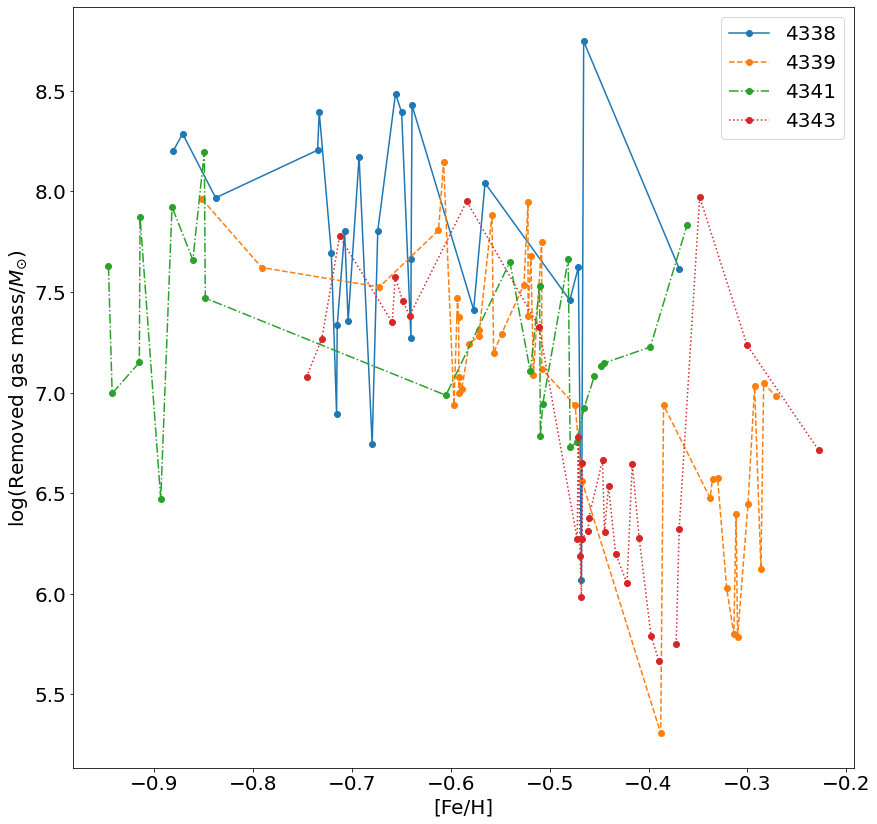

In [40]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(FeH_4338)
ii_4339 = np.argsort(FeH_4339)
ii_4341 = np.argsort(FeH_4341)
ii_4343 = np.argsort(FeH_4343)

pl.plot(FeH_4338[ii_4338], np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(FeH_4339[ii_4339], np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(FeH_4341[ii_4341], np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(FeH_4343[ii_4343], np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('[Fe/H]')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

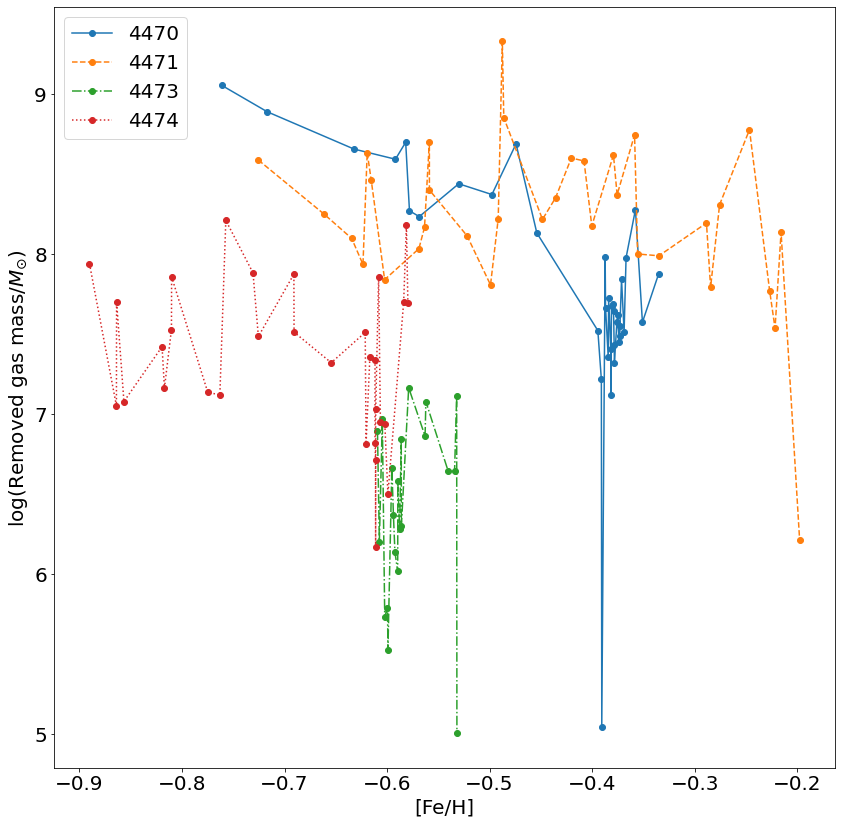

In [41]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(FeH_4470)
ii_4471 = np.argsort(FeH_4471)
ii_4473 = np.argsort(FeH_4473)
ii_4474 = np.argsort(FeH_4474)

pl.plot(FeH_4470[ii_4470], np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(FeH_4471[ii_4471], np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(FeH_4473[ii_4473], np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(FeH_4474[ii_4474], np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('[Fe/H]')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

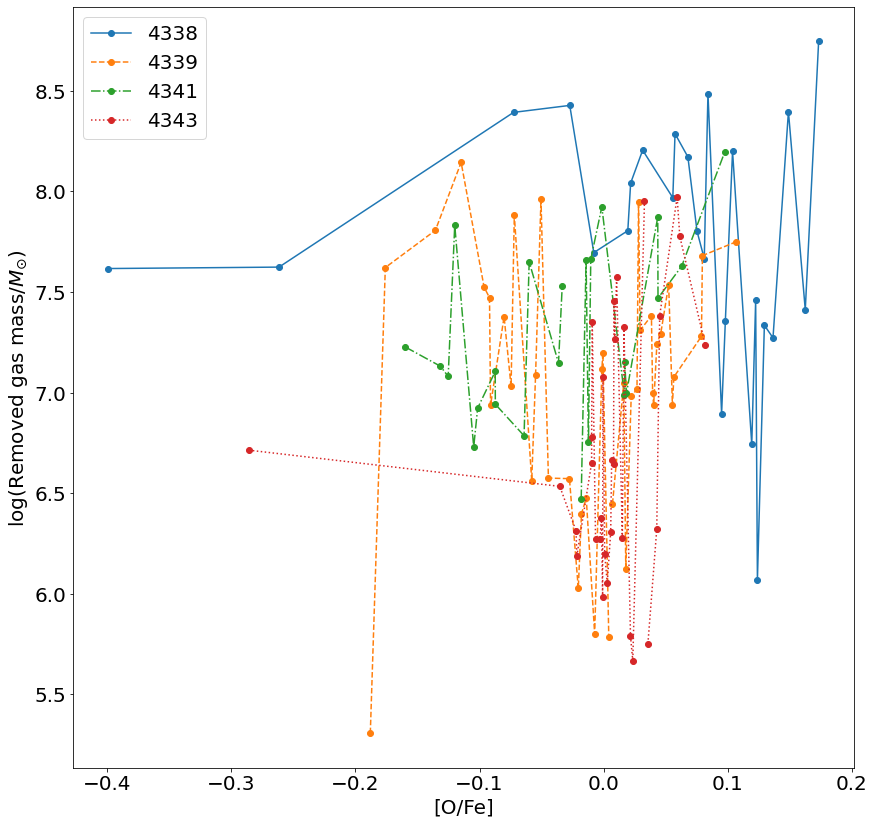

In [42]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(OFe_4338)
ii_4339 = np.argsort(OFe_4339)
ii_4341 = np.argsort(OFe_4341)
ii_4343 = np.argsort(OFe_4343)

pl.plot(OFe_4338[ii_4338], np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(OFe_4339[ii_4339], np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(OFe_4341[ii_4341], np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(OFe_4343[ii_4343], np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('[O/Fe]')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

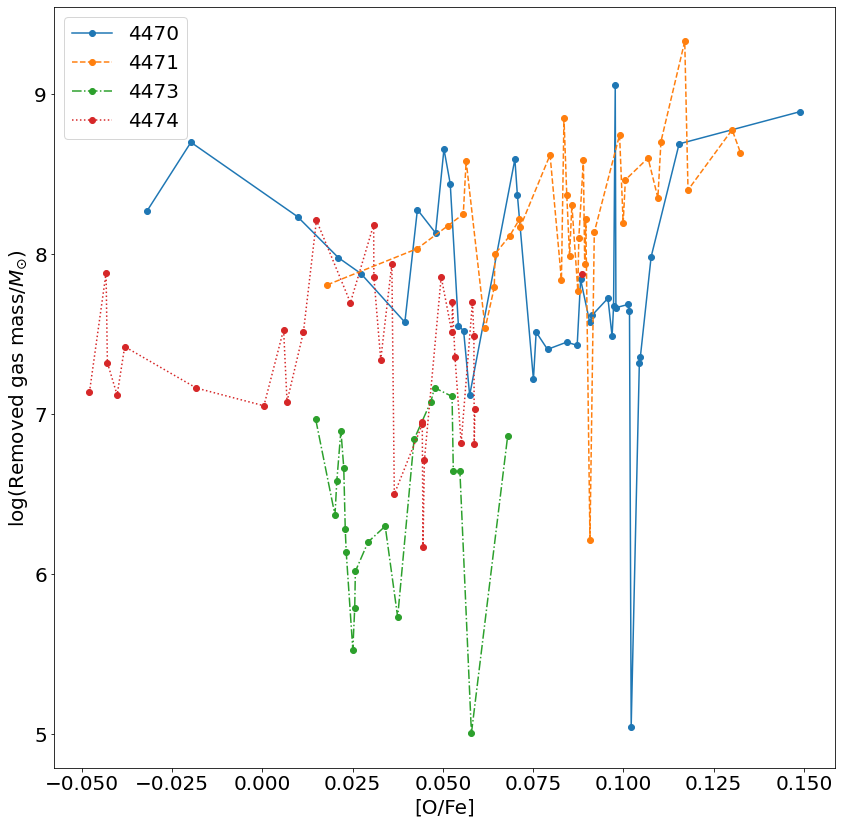

In [43]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(OFe_4470)
ii_4471 = np.argsort(OFe_4471)
ii_4473 = np.argsort(OFe_4473)
ii_4474 = np.argsort(OFe_4474)

pl.plot(OFe_4470[ii_4470], np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(OFe_4471[ii_4471], np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(OFe_4473[ii_4473], np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(OFe_4474[ii_4474], np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('[O/Fe]')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

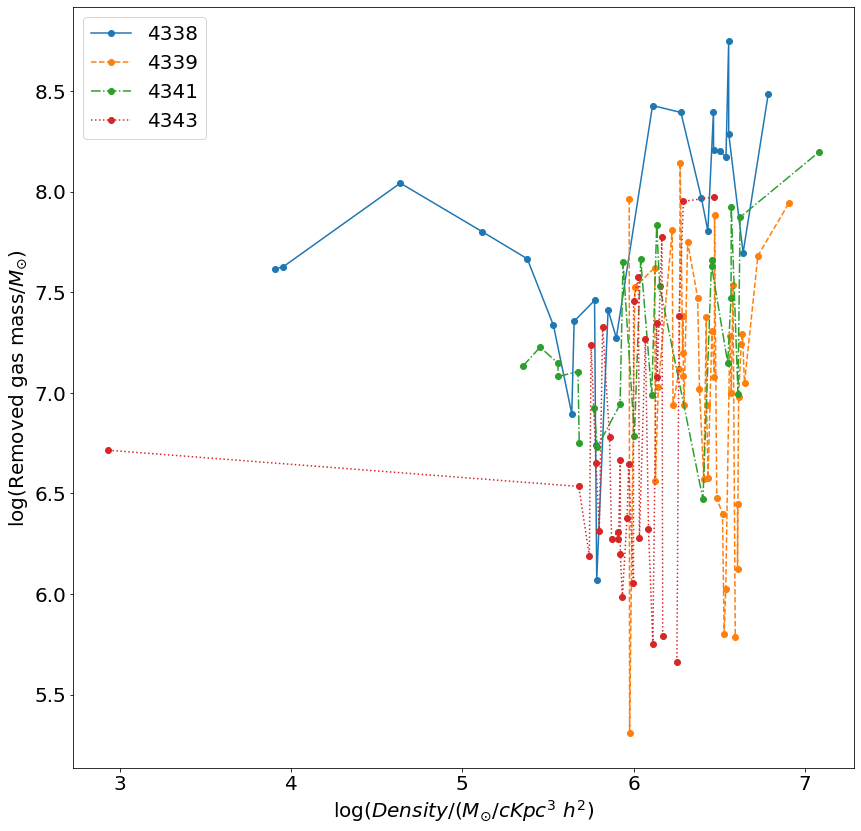

In [44]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(Dens_4338)
ii_4339 = np.argsort(Dens_4339)
ii_4341 = np.argsort(Dens_4341)
ii_4343 = np.argsort(Dens_4343)

pl.plot(np.log10(Dens_4338[ii_4338]), np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(np.log10(Dens_4339[ii_4339]), np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(np.log10(Dens_4341[ii_4341]), np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(np.log10(Dens_4343[ii_4343]), np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

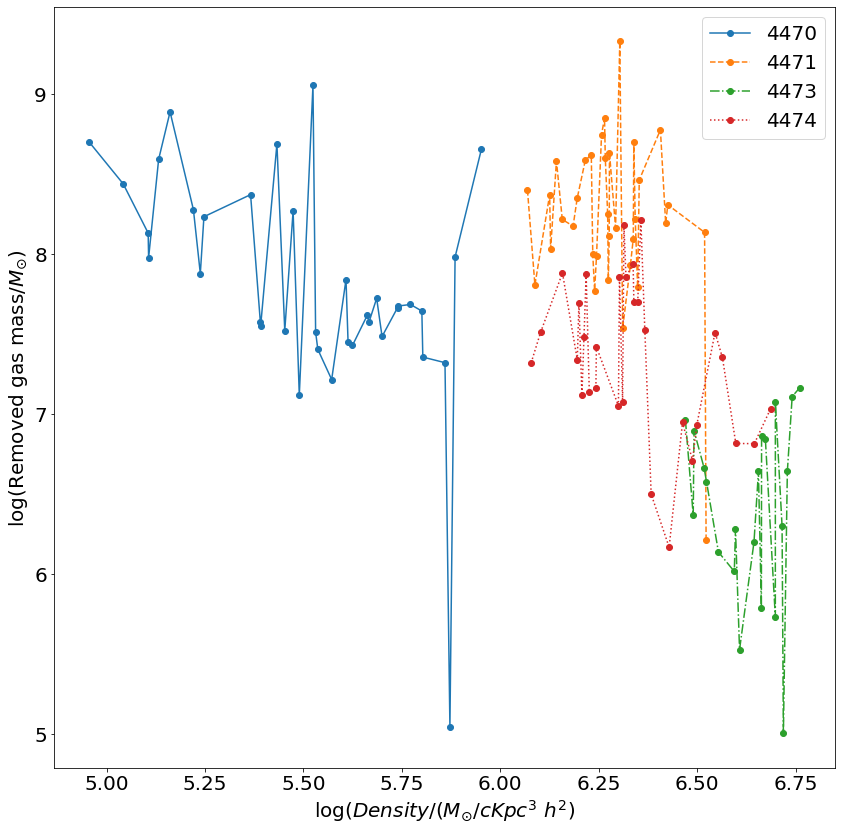

In [45]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(Dens_4470)
ii_4471 = np.argsort(Dens_4471)
ii_4473 = np.argsort(Dens_4473)
ii_4474 = np.argsort(Dens_4474)

pl.plot(np.log10(Dens_4470[ii_4470]), np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(np.log10(Dens_4471[ii_4471]), np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(np.log10(Dens_4473[ii_4473]), np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(np.log10(Dens_4474[ii_4474]), np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log(Density/(M_{\odot}/cKpc^3\,\,h^2)$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

# 